In [1]:
%load_ext autoreload
%autoreload 2

import time
import yaml
import math
import copy
import torch
from torch import nn, optim
import numpy as np
import awkward as ak
import uproot
import pandas as pd
import dask
import vector
import particle
import hepunits

import zuko
import torch
from torch import nn, optim
import lightning as L
from lightning.pytorch import loggers as pl_loggers

from torch.utils.data import DataLoader

from memflow.dataset.data import RootData,ParquetData
from memflow.dataset.dataset import CombinedDataset, MultiCombinedDataset
from memflow.callbacks.transfer_flow_callbacks import *
from memflow.models.custom_flows import *
from memflow.models.transfer_flow_model import TransferFlow

from matplotlib import pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 100})

vector.register_awkward()

print (f"Running on GPU : {torch.cuda.is_available()}")
accelerator = 'gpu' if torch.cuda.is_available() else 'cpu'
print (f"Accelerator : {accelerator}")
torch.set_float32_matmul_precision('medium')  
if accelerator =='gpu':
    torch.cuda.empty_cache()
    print (torch.cuda.memory_summary(device=None, abbreviated=True))

Running on GPU : True
Accelerator : gpu
|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Requested memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|-----------------------

# Datasets

In [1]:
from memflow.HH.dataset_utils import *

# suffixes = ['HH', 'TT','ZZ','ZH','STplus','STminus']
suffixes = ['DY']

combined_datasets = {
    suffix : select_dataset(suffix,build=True,fit=True,N=int(1e6))
    for suffix in suffixes
}

for suffix,dataset in combined_datasets.items():
    print (f'{suffix:10s} : {len(dataset):6d} events')


Loading dataset for DY
Hard data loading
	... done : 4000000 events
Reco data loading
	... done : 4000000 events
Hard dataset
Checking particle quantities
	Particle(s) ('Z',) : required {0, 1}, found {0, 1}
	Particle(s) ('lep_from_Z', 'antilep_from_Z') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_from_nonres', 'antilep_from_nonres') : required {0, 2}, found {0, 2}
	Particle(s) ('lep_from_Z', 'antilep_from_Z', 'lep_from_nonres', 'antilep_from_nonres') : required {2}, found {2}
... done, no problem found
Out of 4000000 events :
  -  1524382 [38.11%] events with n(ISR) = 0
  -   938780 [23.47%] events with n(ISR) = 1
  -  1111725 [27.79%] events with n(ISR) = 2
  -   422720 [10.57%] events with n(ISR) = 3
  -     2393 [0.06%] events with n(ISR) = 4
Required 2 ISR : selecting 1111725 events
Saving objects to /nfs/scratch/fynu/fbury/MEMFlow_data/transfer_flow_v7/dy_hard
Saving preprocessing to /nfs/scratch/fynu/fbury/MEMFlow_data/transfer_flow_v7/dy_hard
Will overwrite what is in outp

DY


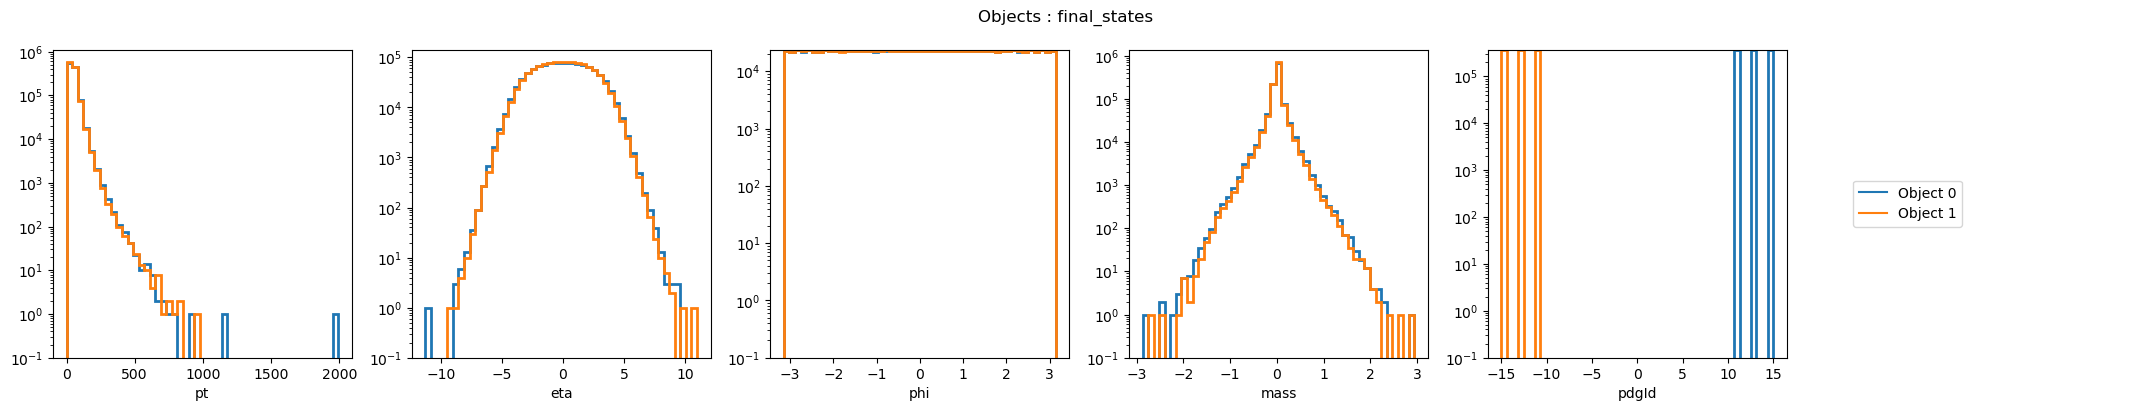

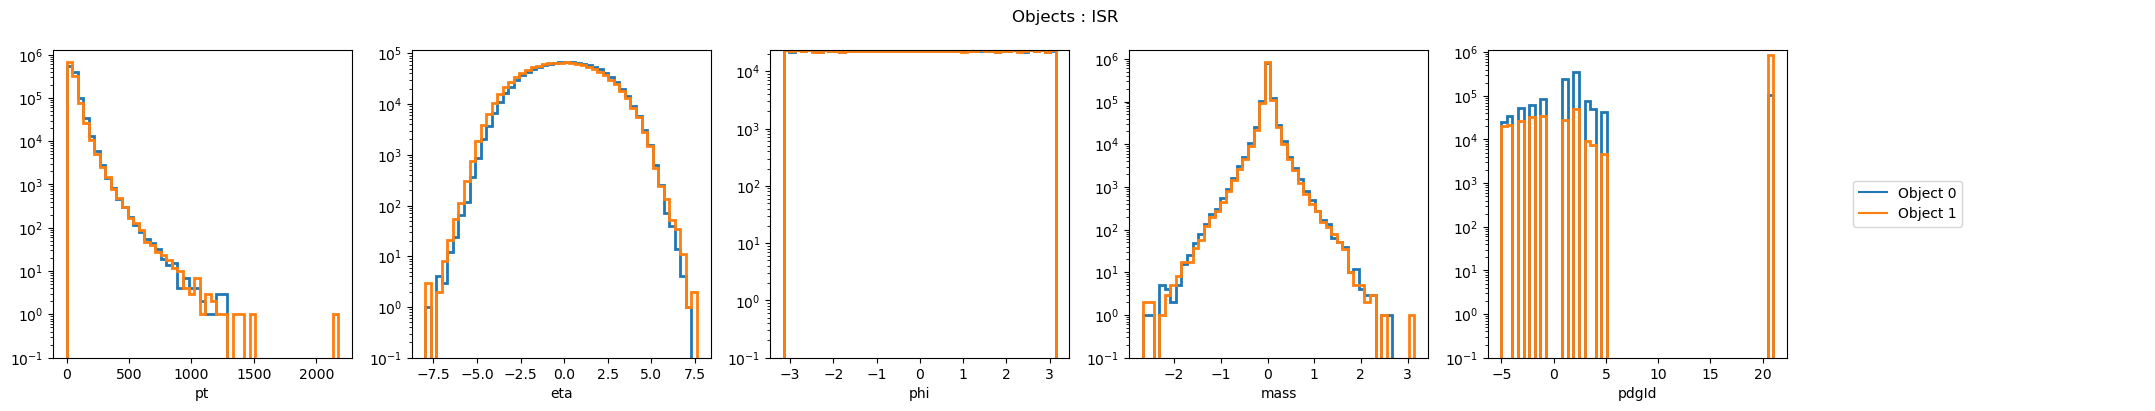

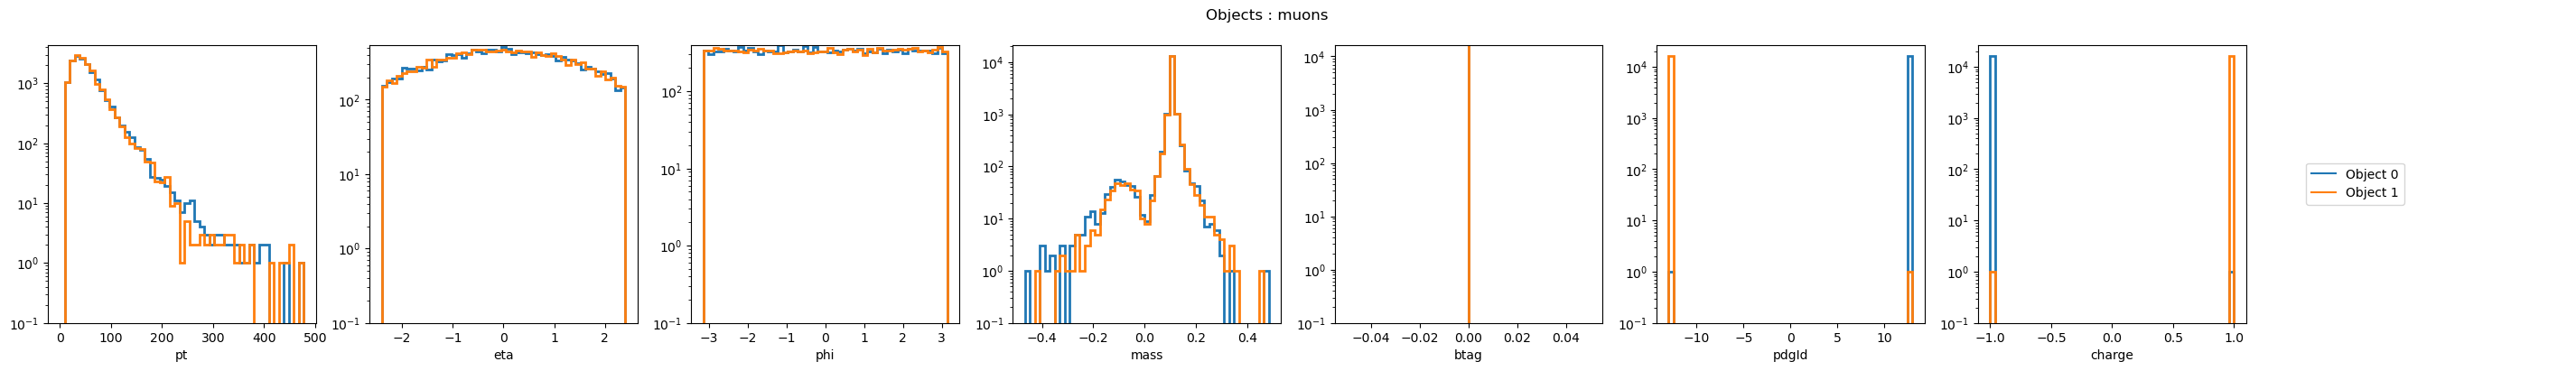

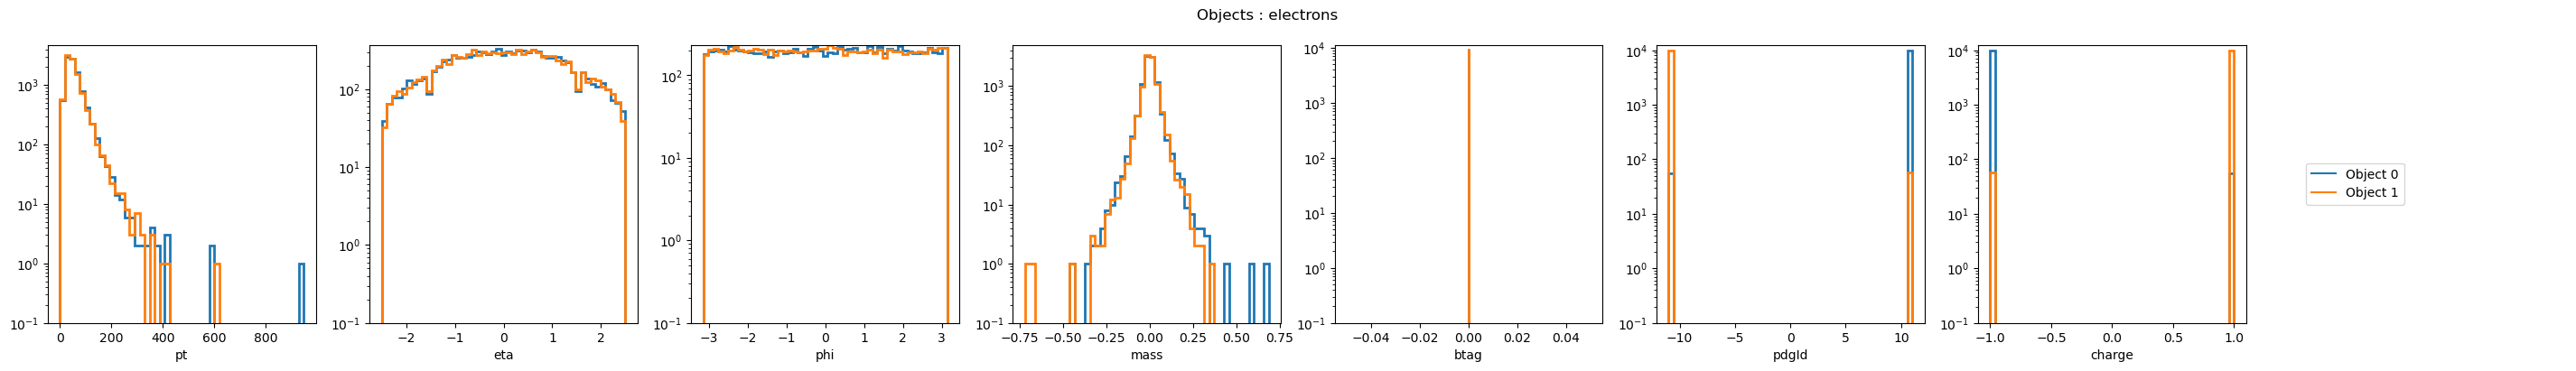

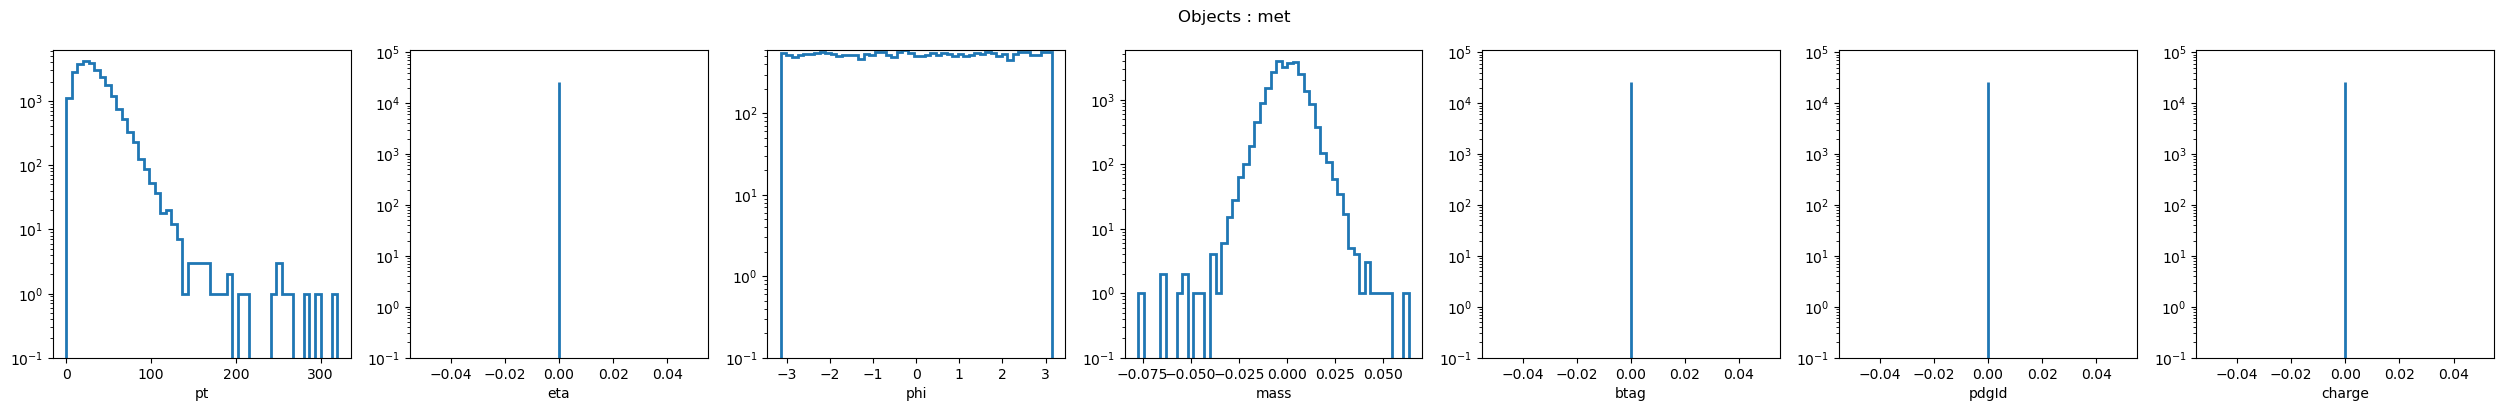

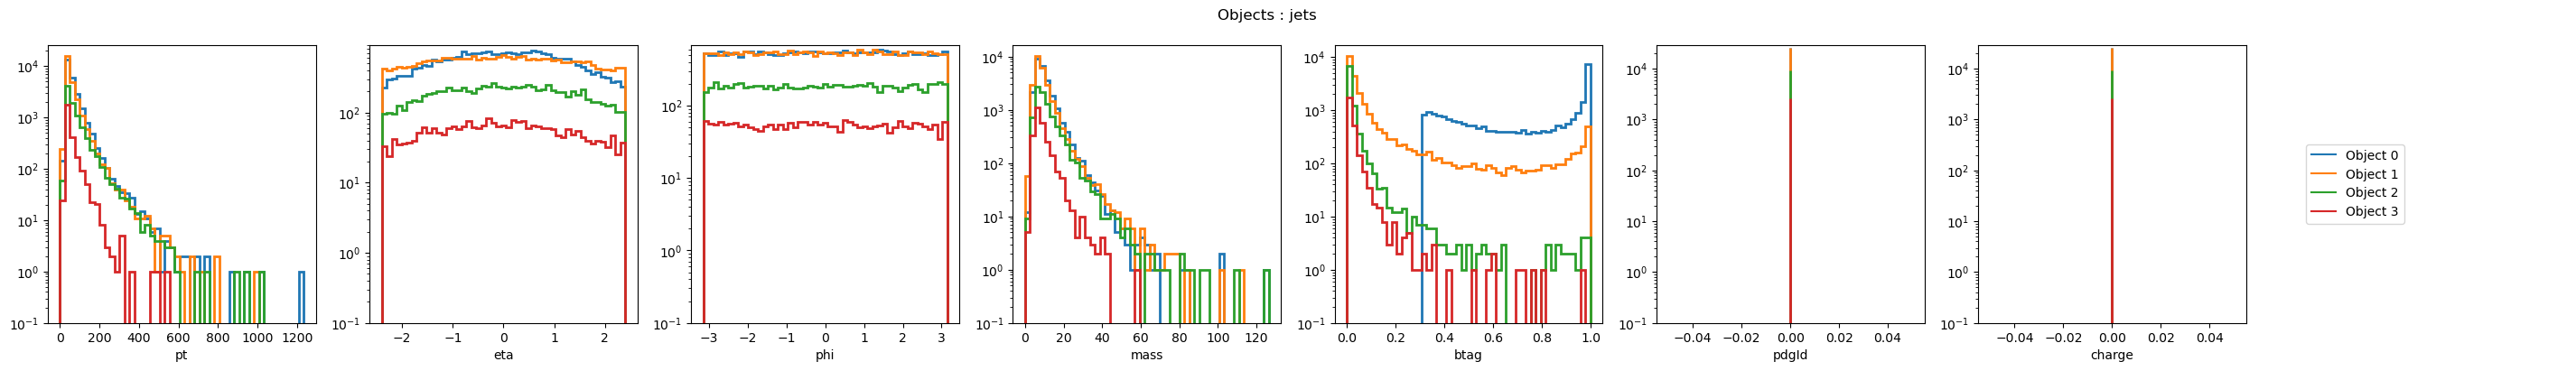

In [3]:
for suffix,dataset in combined_datasets.items():
    print ('='*100)
    print (suffix)
    # dataset.hard_dataset.plot(selection=True,raw=True,log=True)
    # dataset.hard_dataset.plot(fields_to_plot=['pt','eta','phi','mass'],selection=True,raw=False,log=True)
    # dataset.hard_dataset.plot(fields_to_plot='pdgId',selection=True,raw=False,log=True)
    # dataset.reco_dataset.plot(selection=True,raw=True,log=True)
    dataset.hard_dataset.plot(selection=True,raw=True,log=True)
    dataset.reco_dataset.plot(selection=True,raw=True,log=True)


In [5]:
combined_dataset = MultiCombinedDataset(
    datasets = combined_datasets,
)
print (combined_dataset)

Processing the hard datasets
... Undoing preprocessing
... Equalizing datasets
Reweighting factor : 1.00000
... Matching preprocessing

Preprocessing steps
Step applied to ['final_states', 'ISR']
	pdgId  : <class 'memflow.dataset.preprocessing.SklearnScaler'>
  - final_states : ('pdgId',)
  - ISR          : ('pdgId',)
Step applied to ['final_states', 'ISR']
	pt  : <class 'memflow.dataset.preprocessing.logmodulus'>
  - final_states : ('pt',)
  - ISR          : ('pt',)
Step applied to ['final_states', 'ISR']
	pt   : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	eta  : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	phi  : <class 'memflow.dataset.preprocessing.SklearnScaler'>
	m    : <class 'memflow.dataset.preprocessing.SklearnScaler'>
  - final_states : ('pt', 'eta', 'phi', 'm')
  - ISR          : ('pt', 'eta', 'phi', 'm')

Saving preprocessing to /nfs/scratch/fynu/fbury/MEMFlow_data/transfer_flow_v7/dy_hard
Will overwrite what is in output directory /nfs/scratch/fynu/fb

# Training

In [6]:
# Split dataset into training and validation
# Not randomly for reproducilibility, but just based on number
train_frac = 0.9
combined_valid_datasets = {}
combined_train_indices = []
combined_valid_indices = []

n = 0
for suffix,dataset in combined_datasets.items():
    # Get indices per dataset #
    indices = torch.arange(len(dataset))
    sep = int(train_frac*len(dataset))
    train_indices = indices[:sep]
    valid_indices = indices[sep:]
    # Save valid datasets for plottings #
    combined_valid_datasets[suffix] = torch.utils.data.Subset(dataset,valid_indices)
    # Save indices #
    combined_train_indices.append(train_indices + n)
    combined_valid_indices.append(valid_indices + n)
    n += len(dataset)

combined_train_indices = torch.cat(combined_train_indices,dim=0)
combined_valid_indices = torch.cat(combined_valid_indices,dim=0)

combined_dataset_train = torch.utils.data.Subset(combined_dataset,combined_train_indices)
combined_dataset_valid = torch.utils.data.Subset(combined_dataset,combined_valid_indices)

print (f'Dataset : training {len(combined_dataset_train)} / validation {len(combined_dataset_valid)}')

batch_size = 1024

loader_combined_train = DataLoader(
    combined_dataset_train,
    batch_size = batch_size,
    shuffle = True,
)
loader_combined_valid = DataLoader(
    combined_dataset_valid,
    batch_size = 10000,
    shuffle = False,
)
print (f'Batching {len(loader_combined_train)} / Validation {len(loader_combined_valid)}')

Dataset : training 14356 / validation 1596
Batching 15 / Validation 1


In [7]:
# Combined transfer flow #
model = TransferFlow(
    # General args #
    dropout = 0.,
    process_names = combined_dataset.names,
    # Embedding arguments #
    embed_dims = [32,64],
    embed_act = nn.GELU,
    # Particle features, names, masks, and number for printouts and logging #
    n_hard_particles_per_type = combined_dataset.hard_datasets[0].number_particles_per_type,
    hard_particle_type_names = combined_dataset.hard_datasets[0].selection,
    hard_input_features_per_type = combined_dataset.hard_datasets[0].input_features,
    n_reco_particles_per_type = combined_dataset.reco_datasets[0].number_particles_per_type,
    reco_particle_type_names = combined_dataset.reco_datasets[0].selection,
    reco_input_features_per_type = combined_dataset.reco_datasets[0].input_features,
    flow_input_features = [ # features to be used in the flows (different from the tranformer)
        ['pt','eta','phi','mass'], # muons
        ['pt','eta','phi','mass'], # electrons
        ['pt','phi'],              # met
        ['pt','eta','phi','mass'], # jets
    ],
    hard_mask_attn = None, #combined_dataset.hard_datasets[0].attention_mask,
    reco_mask_attn = combined_dataset.reco_datasets[0].attention_mask,
    # Transformer arguments #
    onehot_encoding = False, # add onehot encoded position vector to particles
    transformer_args = { # to be passed to the Transformer pytorch class
        'nhead' : 8,
        'num_encoder_layers' : 8, 
        'num_decoder_layers' : 8, 
        'dim_feedforward' : 128, 
        'activation' : 'gelu', 
    },
    # Flow args #
    flow_common_args = { # common args for all flows
        'bins' : 16,
        'transforms' : 5,
        'randperm' : True,
        'passes' : None,
        'hidden_features' : [128] * 2,   
    },
    flow_classes = { # classes for each feature
        'pt'  : zuko.flows.NSF,
        'eta' : UniformNSF,
        'phi' : UniformNCSF,
        'mass': zuko.flows.NSF,
    },
    flow_specific_args = { # specific args for each class above
        'eta' : {'bound' : 1.},
        'phi' : {'bound' : 1.},
    },
    flow_mode = 'global', # 'global', 'type' or 'particle'
)
model = model.cpu()

batch = next(iter(loader_combined_train))

log_probs, mask, weights = model(batch)
mask = mask > 0
print ('log_probs',log_probs,log_probs.shape)
print ('mask',mask,mask.shape)
print ('weights',weights,weights.shape)

log_probs_tot = model.shared_eval(batch,0,'test')
print ('tot log probs',log_probs_tot)

samples = model.sample(batch['hard']['data'],batch['hard']['mask'],batch['reco']['data'],batch['reco']['mask'],N=100)
print ('samples')
for sample in samples:
    print ('\t',sample.shape)

print (model)

No hard attention mask provided, will use the exist mask for the attention


/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim=-1)


log_probs tensor([[1.9437, 3.6177, 3.3596,  ..., 5.0194, 3.9795, 3.3517],
        [3.0501, 3.9456, 3.3107,  ..., 5.1507, 3.3331, 3.4557],
        [4.0651, 4.3191, 4.6160,  ..., 5.5571, 4.1616, 4.0935],
        ...,
        [4.1328, 4.1156, 3.3671,  ..., 5.2515, 4.0104, 4.0170],
        [3.3445, 3.6510, 3.2794,  ..., 6.4619, 3.5475, 3.5138],
        [3.5823, 3.7389, 4.5932,  ..., 2.9869, 3.6871, 3.7259]],
       grad_fn=<NegBackward0>) torch.Size([1024, 9])
mask tensor([[ True,  True, False,  ...,  True,  True, False],
        [ True,  True, False,  ...,  True, False, False],
        [False, False,  True,  ...,  True, False, False],
        ...,
        [False, False,  True,  ...,  True, False, False],
        [False, False,  True,  ...,  True, False, False],
        [False, False,  True,  ...,  True, False, False]]) torch.Size([1024, 9])
weights tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/pytorch/core/module.py:447: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


tot log probs tensor(3.8977, grad_fn=<MeanBackward0>)
samples
	 torch.Size([100, 1024, 2, 4])
	 torch.Size([100, 1024, 2, 4])
	 torch.Size([100, 1024, 1, 2])
	 torch.Size([100, 1024, 4, 4])
TransferFlow(
  (hard_embeddings): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=5, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (reco_embeddings): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=7, out_features=32, bias=True)
      (1): GELU(approximate='none')
      (2): Linear(in_features=32, out_features=64, bias=True)
    )
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-7): 8 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
          )
          (linear1): Linear(in_features=64, ou

In [8]:
biases = [
     BiasCallback(
        dataset = combined_valid_datasets[suffix],
        preprocessing = combined_datasets[suffix].reco_dataset._preprocessing,
        N_sample = 100,
        frequency = 10,
        bins = 51,
        points = 20,
        log_scale = True,
        batch_size = 5000,
        #N_batch = 1,
        suffix = suffix,
        label_names = {
            'pt' : 'p_T',
            'eta' : '\eta',
            'phi' : '\phi',
            'mass' : 'M',
        },
    )
    for suffix in suffixes
]

# for bias in biases:
#     bias.make_bias_plots(model.cuda(),show=True)

In [9]:
##### Parameters #####
epochs = 200
steps_per_epoch_train = math.ceil(len(combined_dataset_train)/loader_combined_train.batch_size)

print (f'Training   : Batch size = {loader_combined_train.batch_size} => {steps_per_epoch_train} steps per epoch')
##### Optimizer #####
optimizer = optim.Adam(model.parameters(), lr=1e-4)
model.set_optimizer(optimizer)

##### Scheduler #####
# scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer = optimizer, 
#     max_lr = 1e-3, 
#     epochs = epochs, 
#     steps_per_epoch = steps_per_epoch_train, 
#     pct_start = 0.25,
#     anneal_strategy='linear', 
#     cycle_momentum=True, 
#     base_momentum=0.85, 
#     max_momentum=0.95, 
#     div_factor=1e1, 
#     final_div_factor=1e1,
#     three_phase = True,
# )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = optimizer,
    mode='min', 
    factor=0.1, 
    patience=10, 
    threshold=0.001, 
    threshold_mode='rel', 
    cooldown=0, 
    min_lr=1e-7
)
model.set_scheduler_config(
    {
        'scheduler' : scheduler,
        'interval' : 'step' if isinstance(scheduler,optim.lr_scheduler.OneCycleLR) else 'epoch',
        'frequency' : 1,
        'monitor' : 'val/loss_tot',
        'strict' : True,
        'name' : 'scheduler',
    }
)

##### Callbacks #####
callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval = 'epoch'),
    L.pytorch.callbacks.ModelSummary(max_depth=2),
] + biases

##### Logger #####
logger = pl_loggers.CometLogger(
    save_dir = '../comet_logs',
    project_name = 'mem-flow-HH',
    experiment_name = 'combined',
    offline = False,
) 
logger.log_graph(model)
# logger.log_hyperparams()
# logger.experiment.log_code(folder='../src/')
logger.experiment.log_notebook(filename=globals()['__session__'],overwrite=True)

##### Trainer #####
trainer = L.Trainer(    
    min_epochs = 5,
    max_epochs = epochs,
    callbacks = callbacks,
    devices = 'auto',
    accelerator = accelerator,
    logger = logger,
    log_every_n_steps = steps_per_epoch_train/100,
)
##### Fit #####
trainer.fit(
    model = model, 
    train_dataloaders = loader_combined_train,
    val_dataloaders = loader_combined_valid,
)

Training   : Batch size = 1024 => 15 steps per epoch


CometLogger will be initialized in online mode
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/florianbury/mem-flow-hh/bdea2b9ba4404262bb3a9bdb96df59ed

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/ ...
Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callb

Sanity Checking: |                                                                                            …

/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/torch/nn/modules/transformer.py:380: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/NestedTensorImpl.cpp:178.)
  output = torch._nested_tensor_from_mask(output, src_key_padding_mask.logical_not(), mask_check=False)
/home/ucl/cp3/fbury/scratch/anaconda3/envs/mem-flow/lib/python3.10/site-packages/zuko/transforms.py:494: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /opt/conda/conda-bld/pytorch_1699449181202/work/aten/src/ATen/native/BucketizationUtils.h:32.)
  return torch.searchsorted(seq, value).squeeze(dim

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

infs at coordinates [tensor([364], device='cuda:0'), tensor([7], device='cuda:0')]


Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=200` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : combined
COMET INFO:     url                   : https://www.comet.com/florianbury/mem-flow-hh/bdea2b9ba4404262bb3a9bdb96df59ed
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     scheduler [200]            : (1e-05, 0.0001)
COMET INFO:     val/loss_electrons_0 [200] : (-1.6758953332901, 2.605905055999756)
COMET INFO:     val/loss_electrons_1 [200] : (-7.7533416748046875, 2.839306116104126)
COMET INFO:     val/loss_jets_0 [200]      : (1.2686294317245483, 3.7545297145843506)
COMET INFO:     val/loss_jets_1 [200]      : (1.3400861024856567, 3.8971691131591797)
COMET INFO:     val/loss_jets_2 [200]

Predict: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.10it/s]


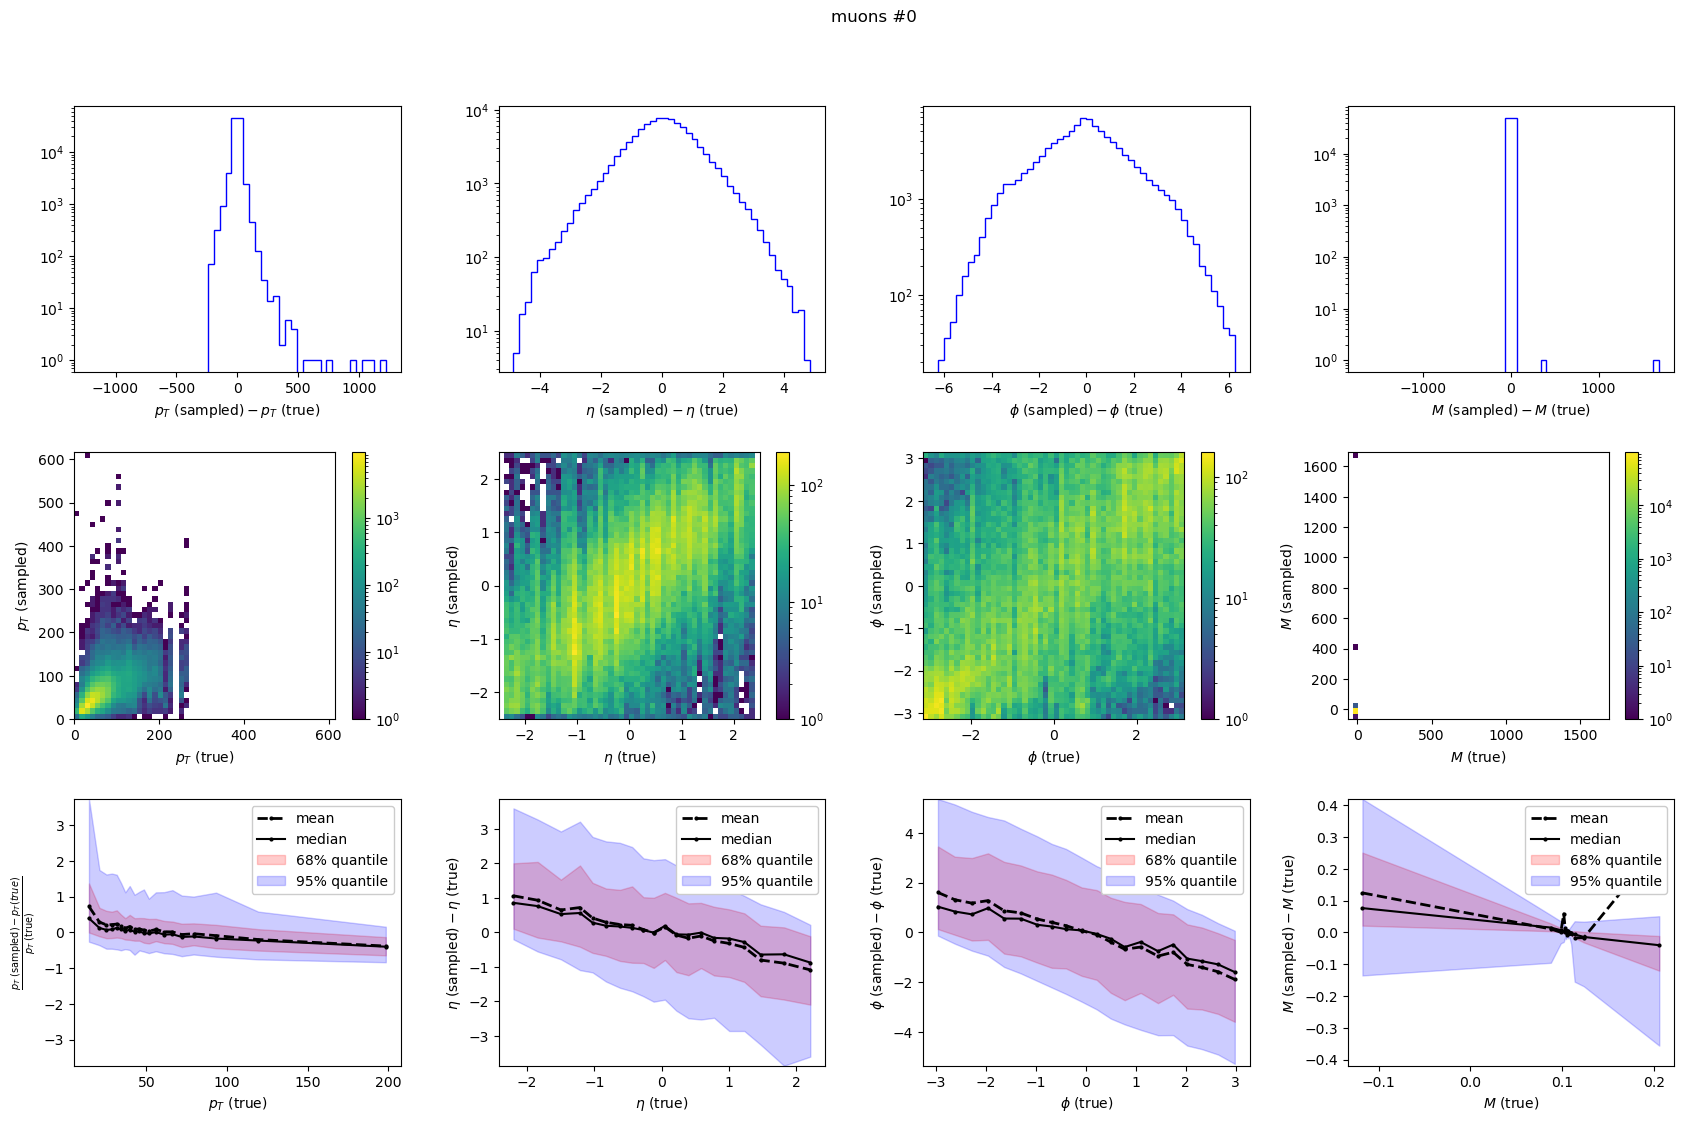

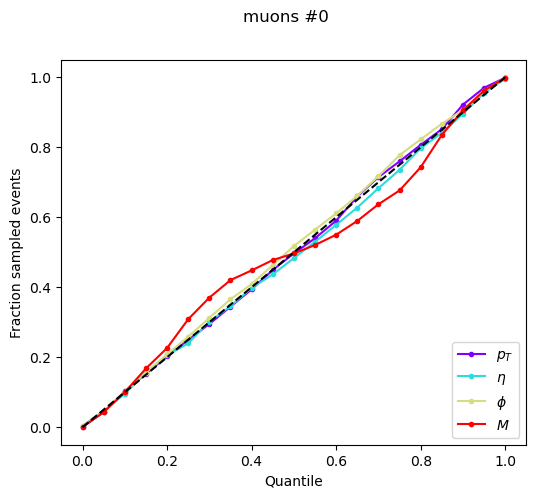

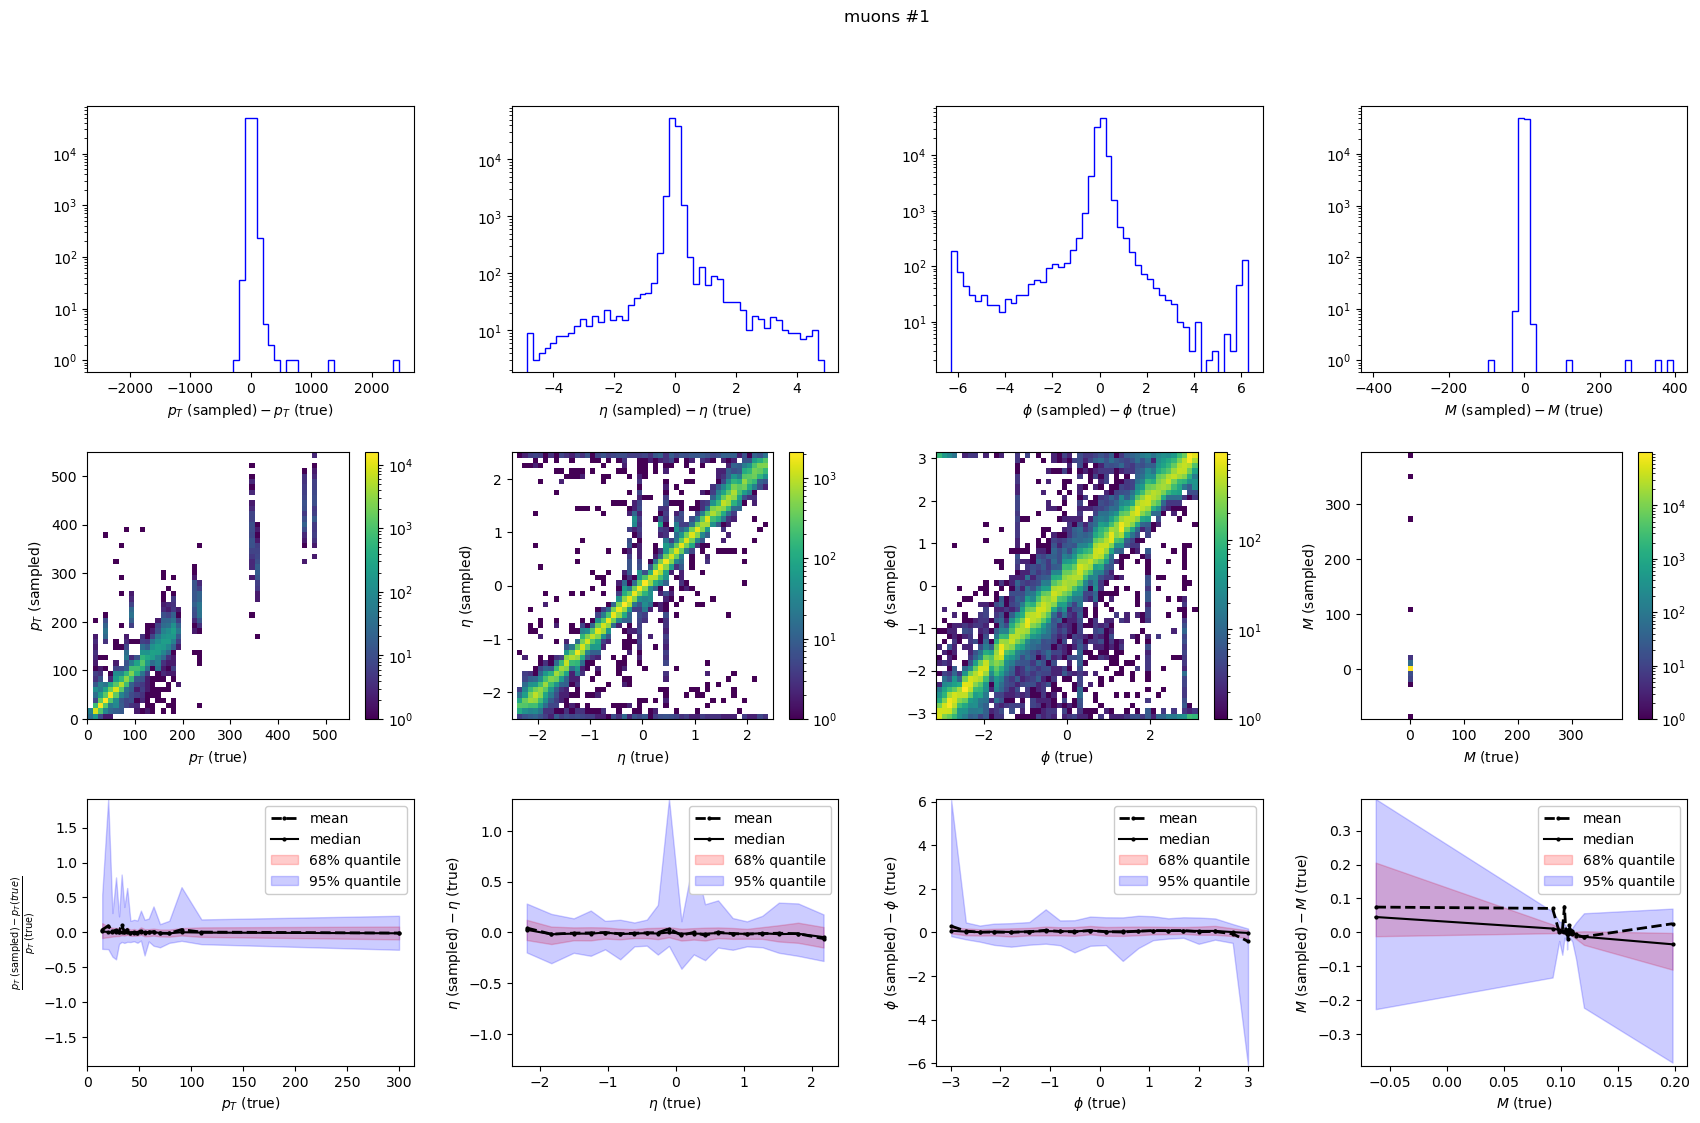

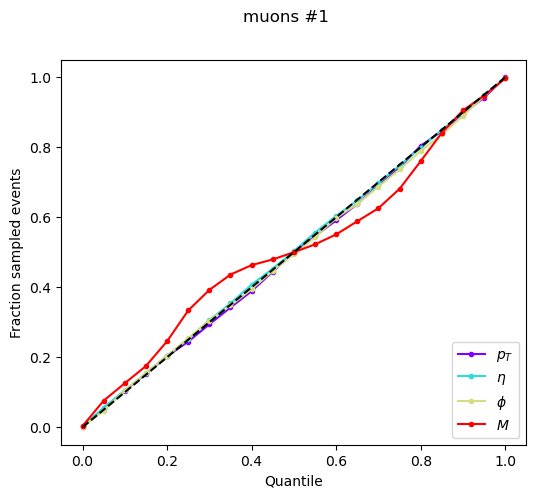

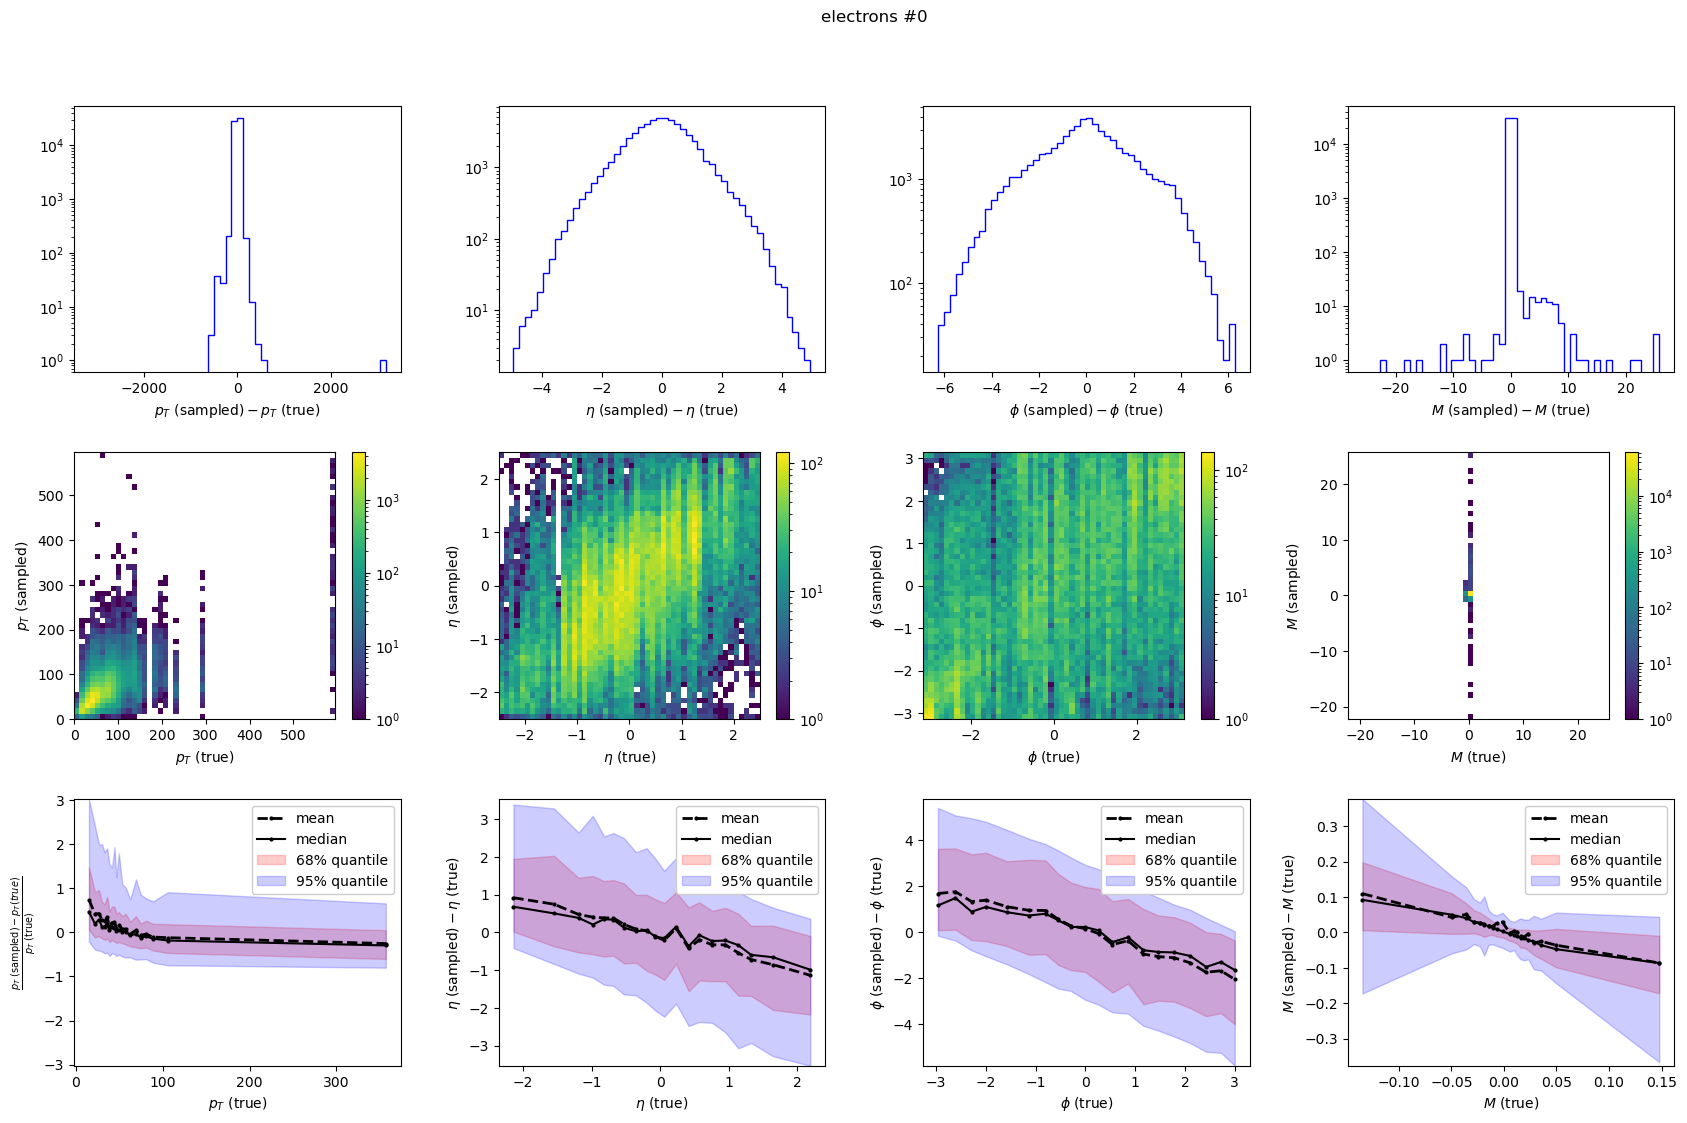

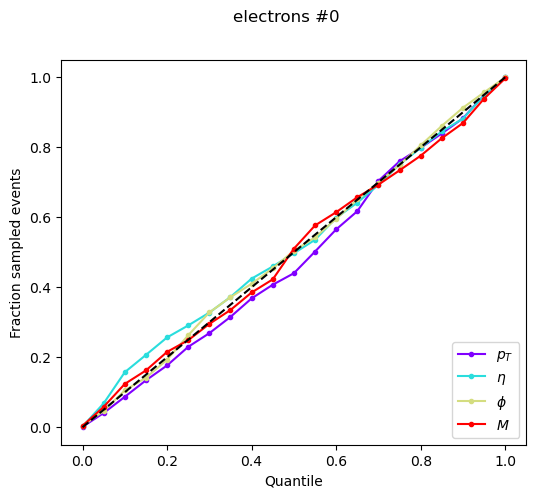

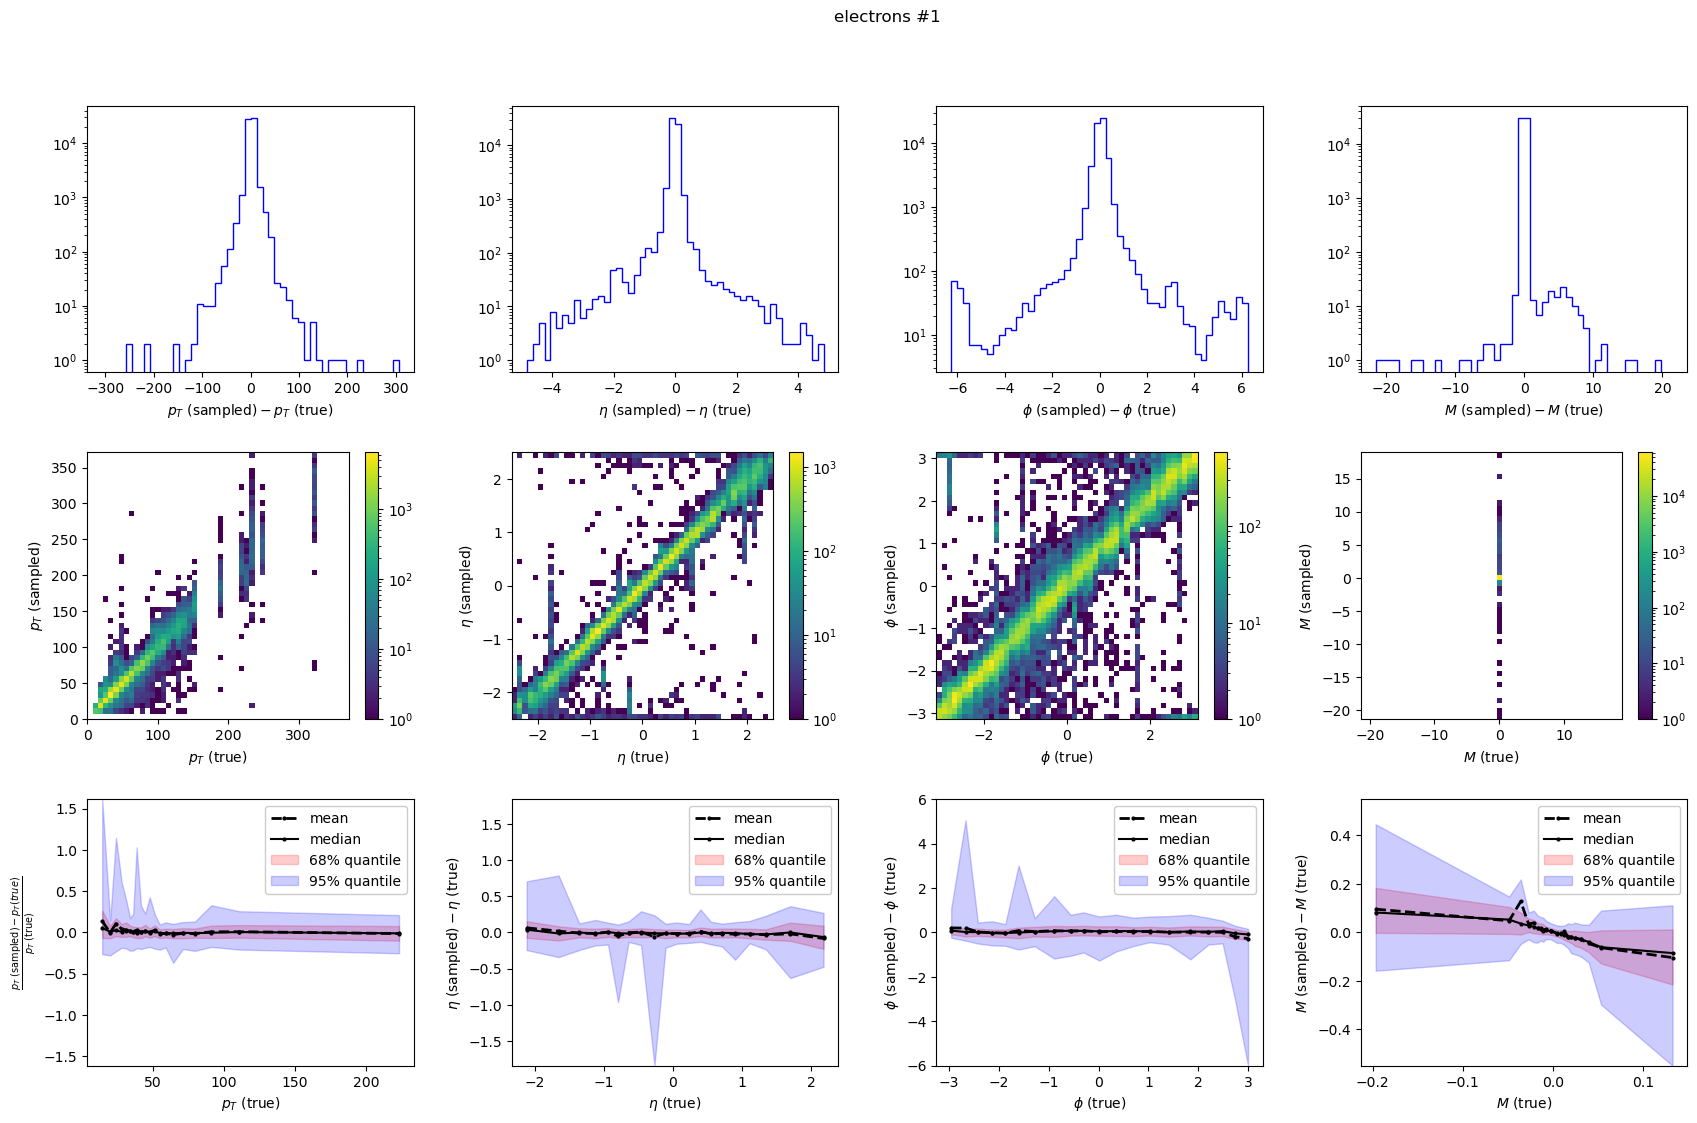

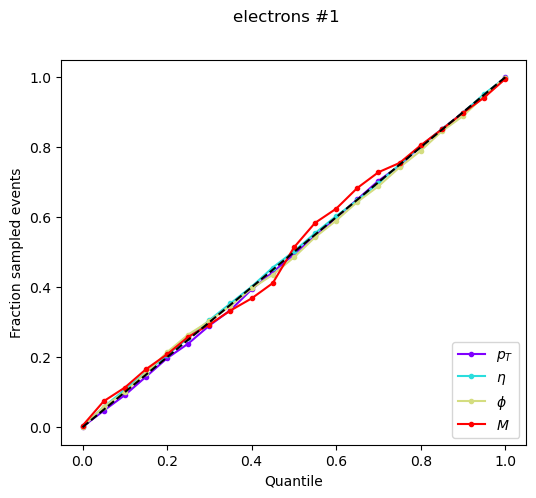

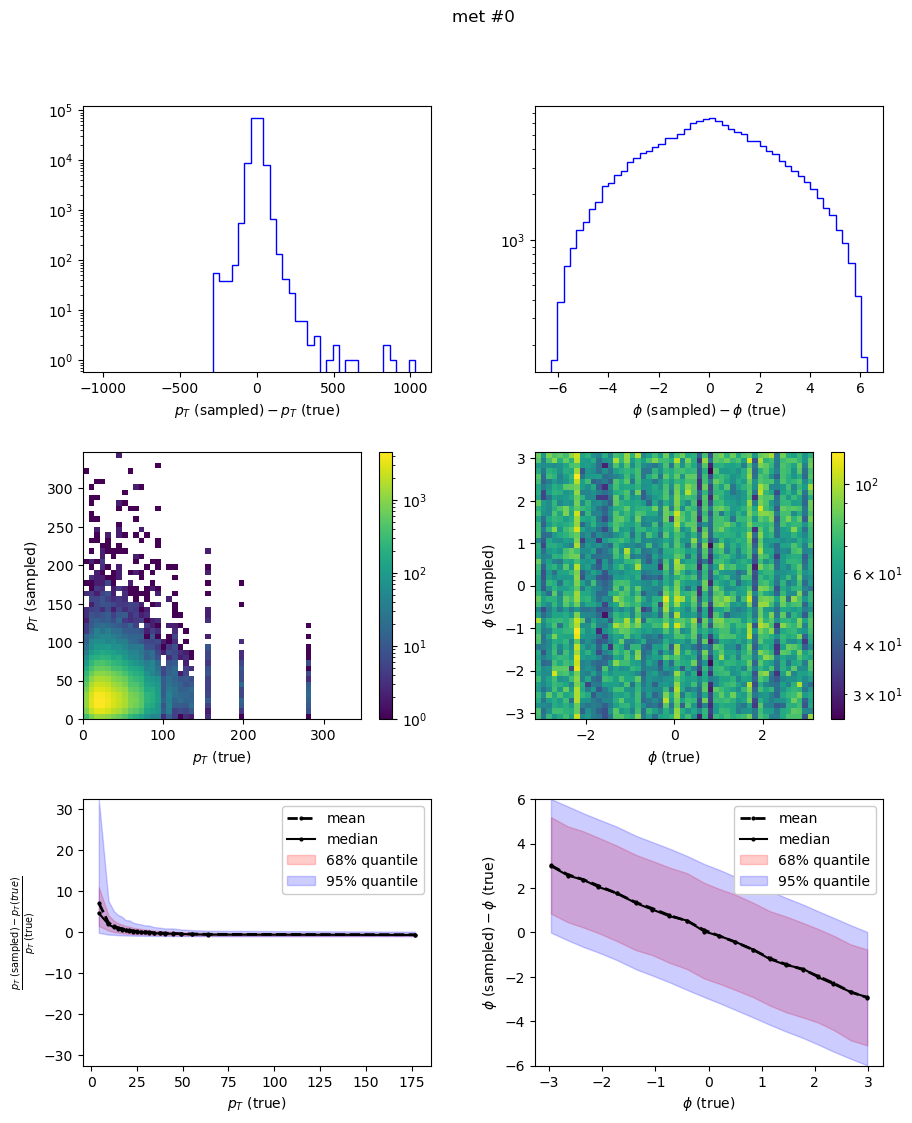

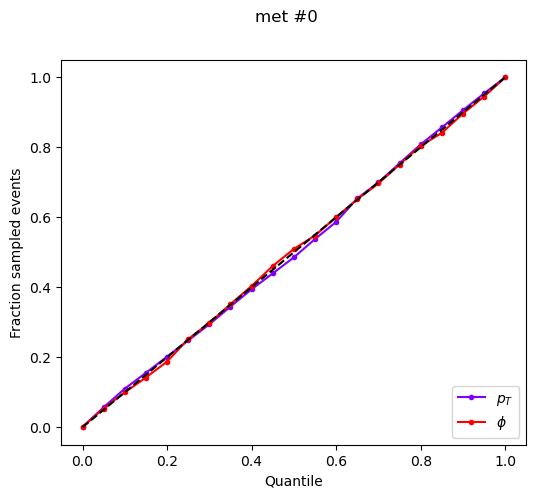

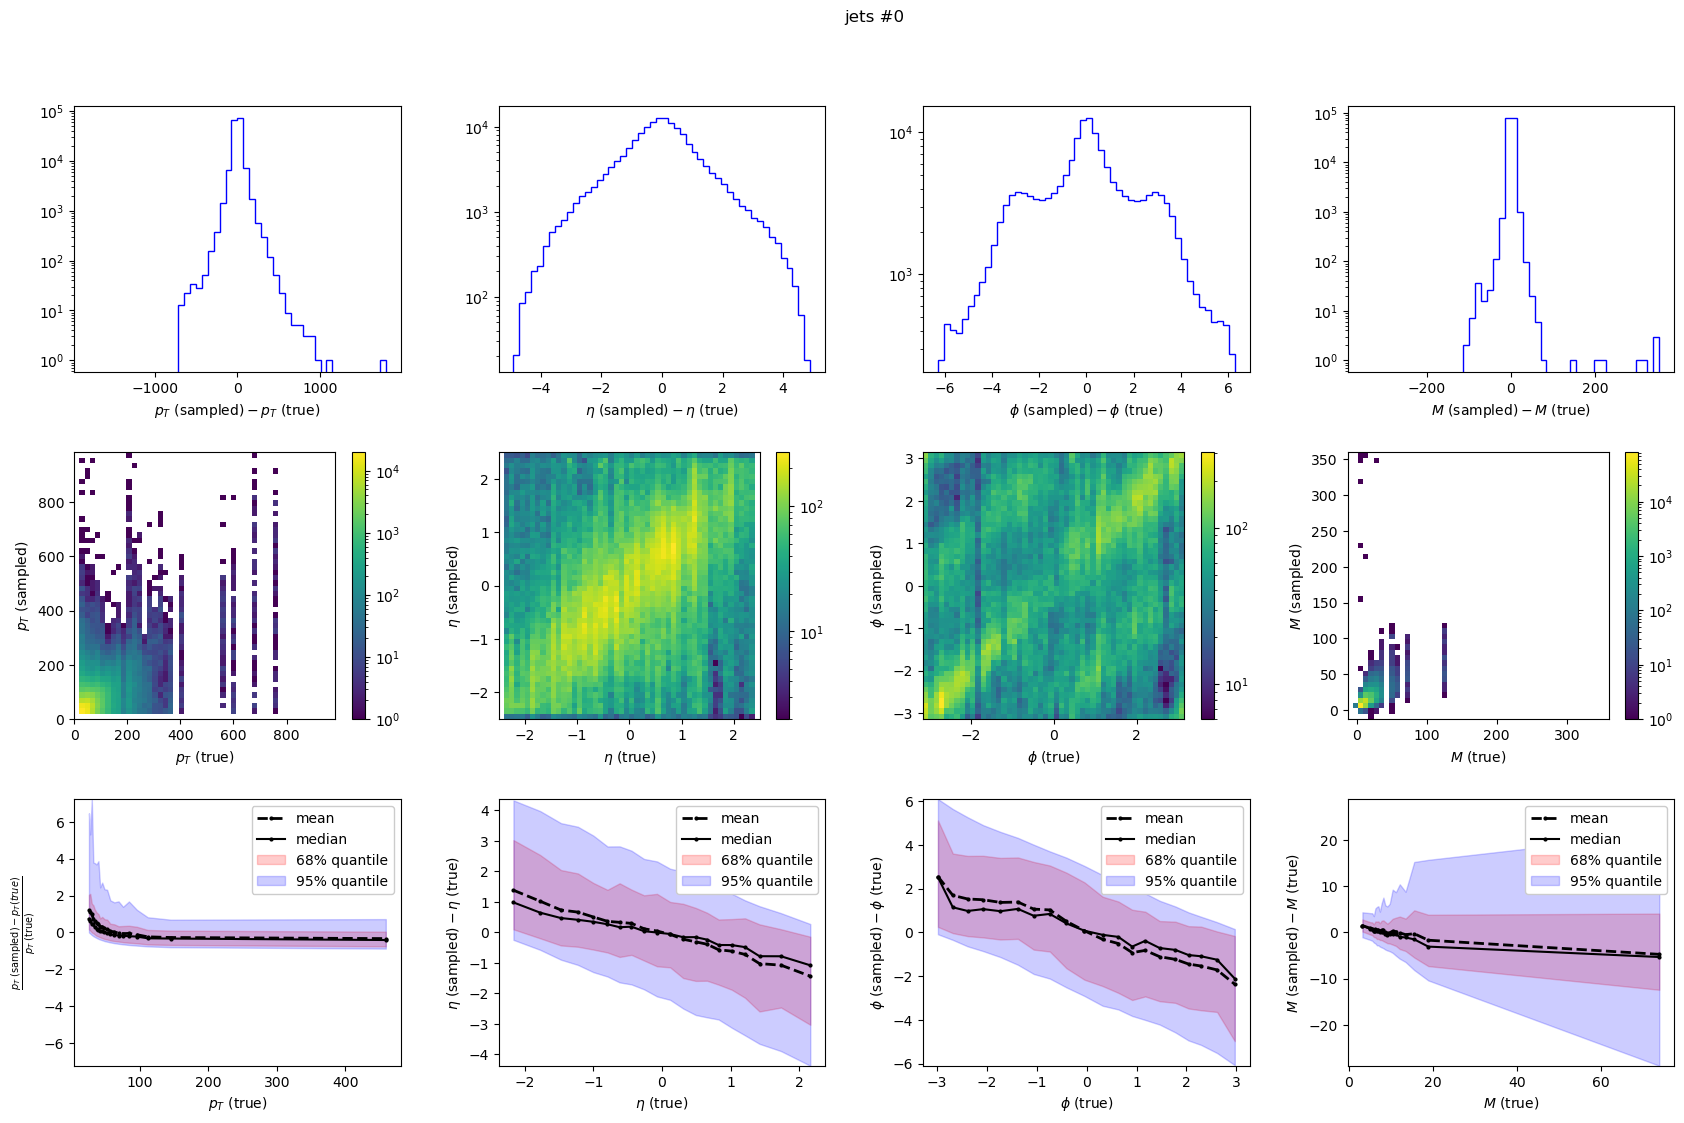

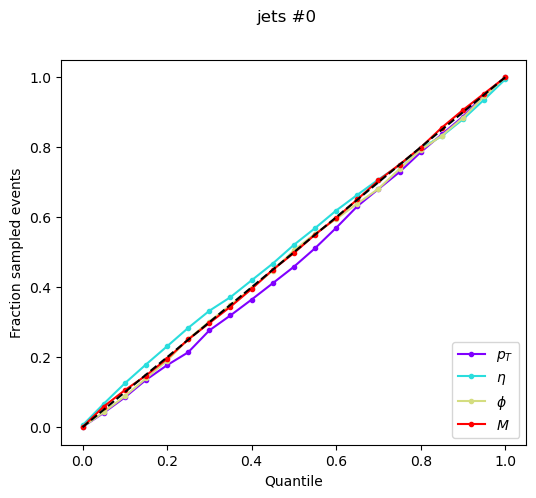

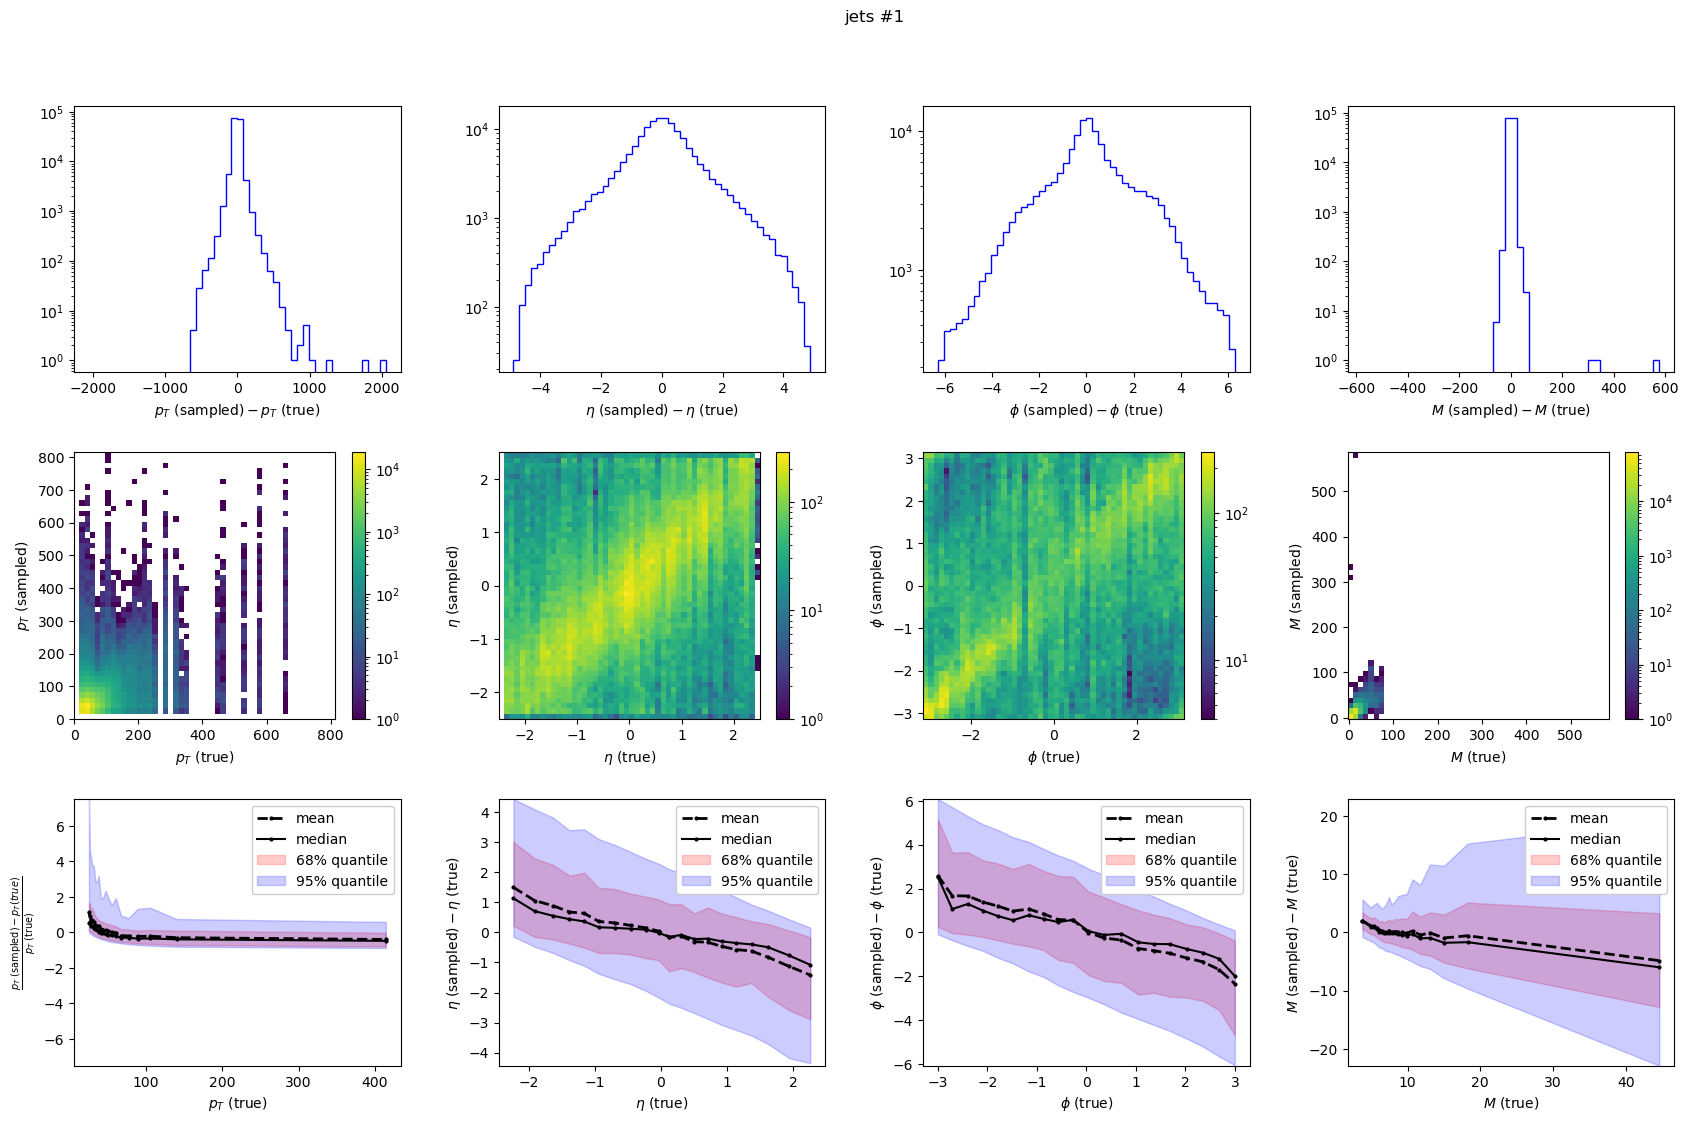

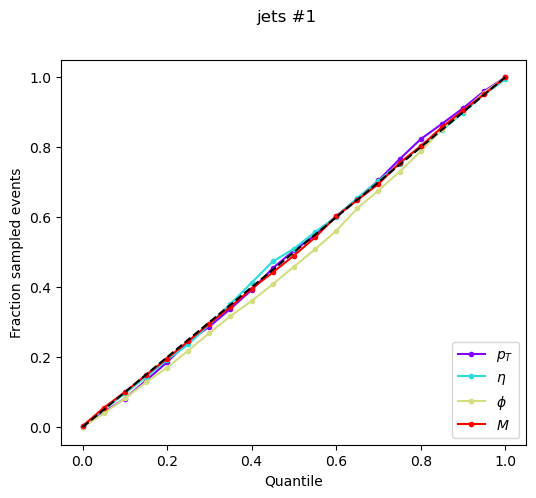

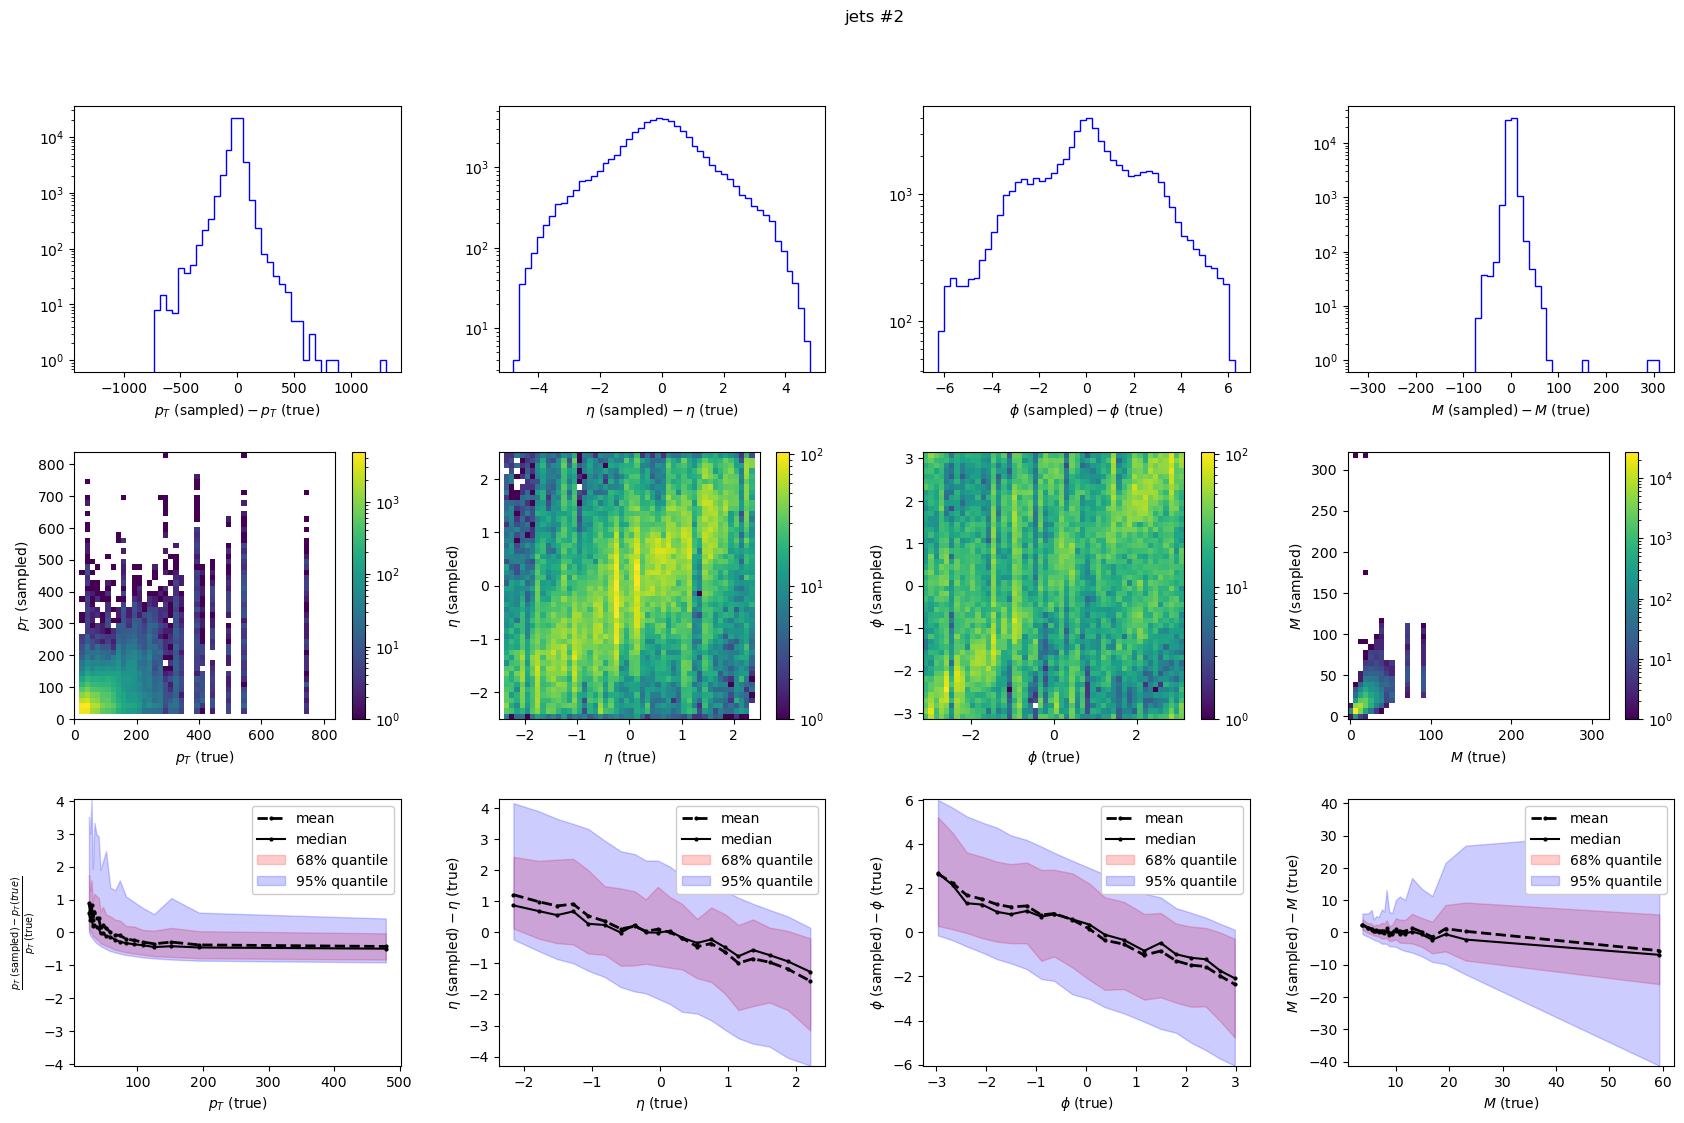

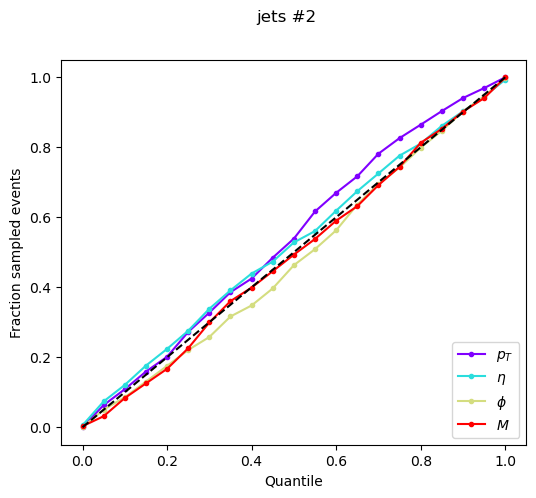

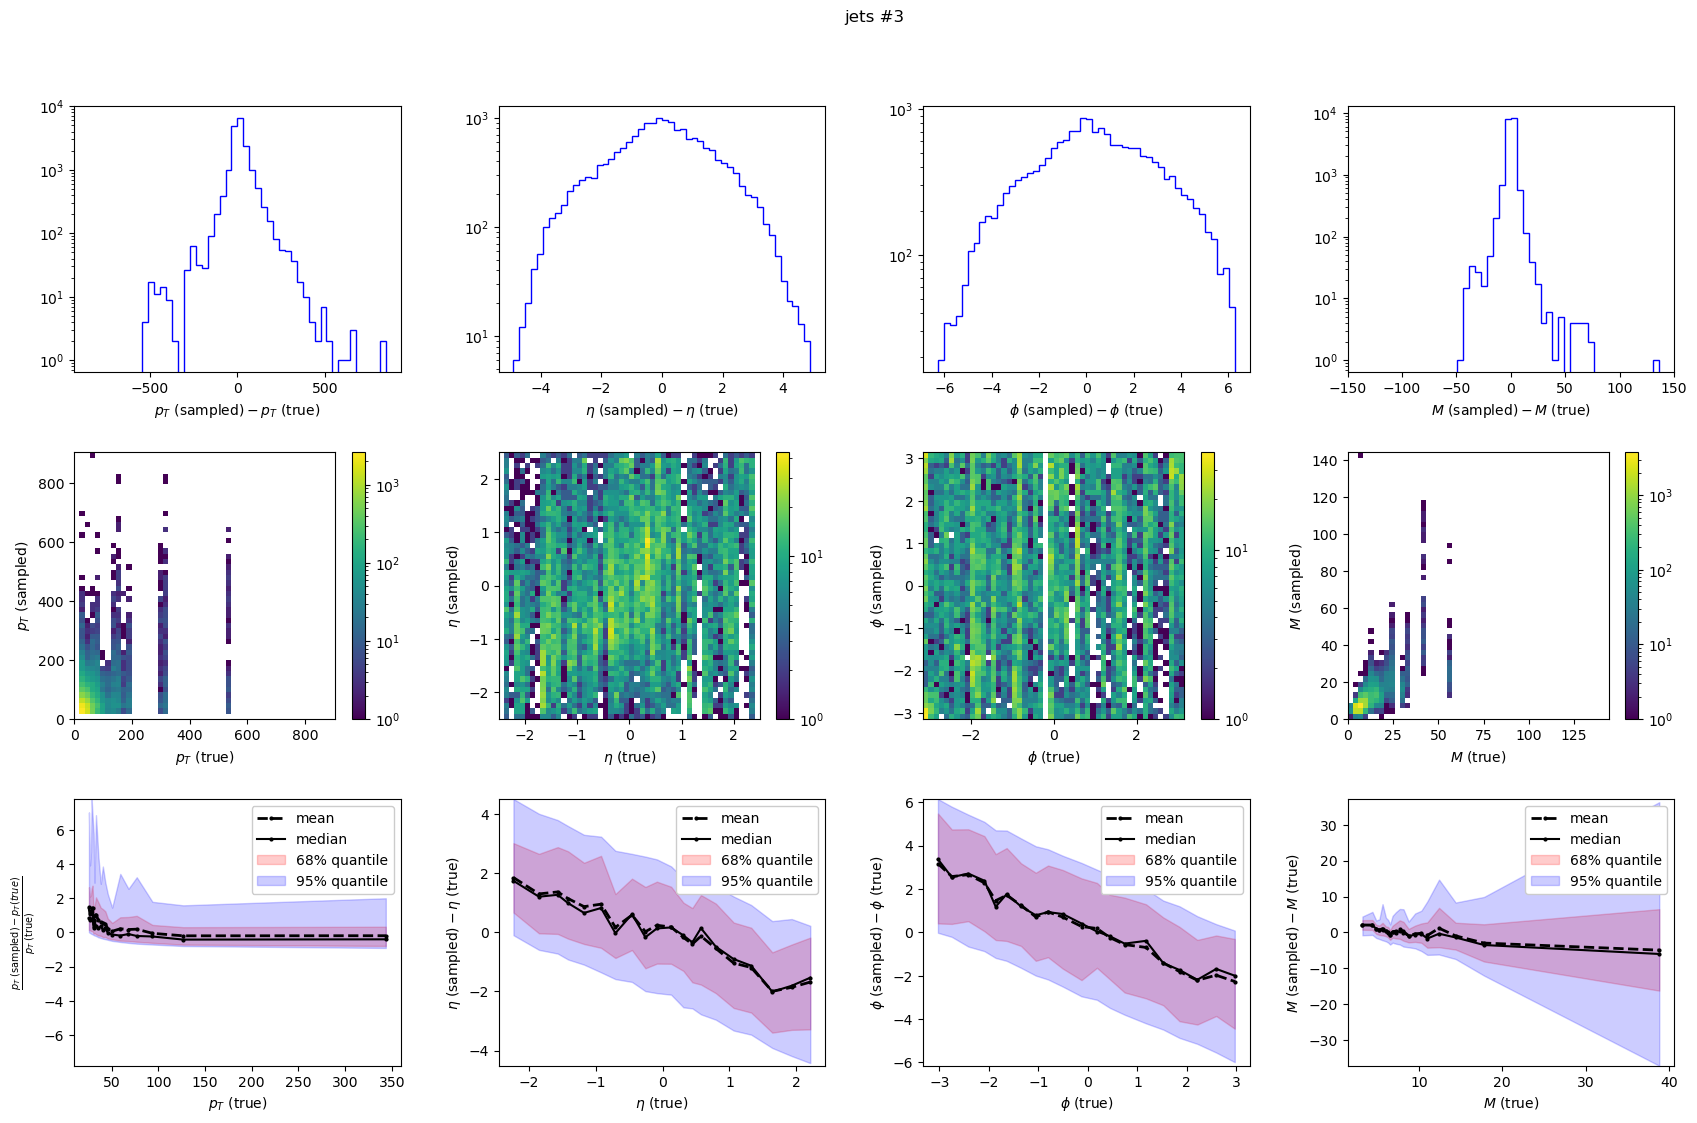

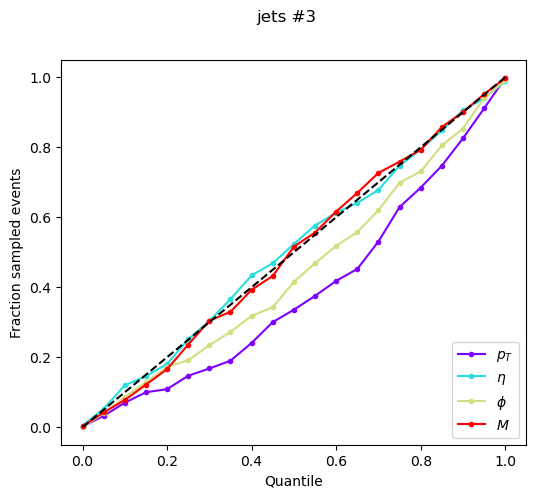

In [10]:
for bias in biases:
    bias.make_bias_plots(model.cuda(),show=True)

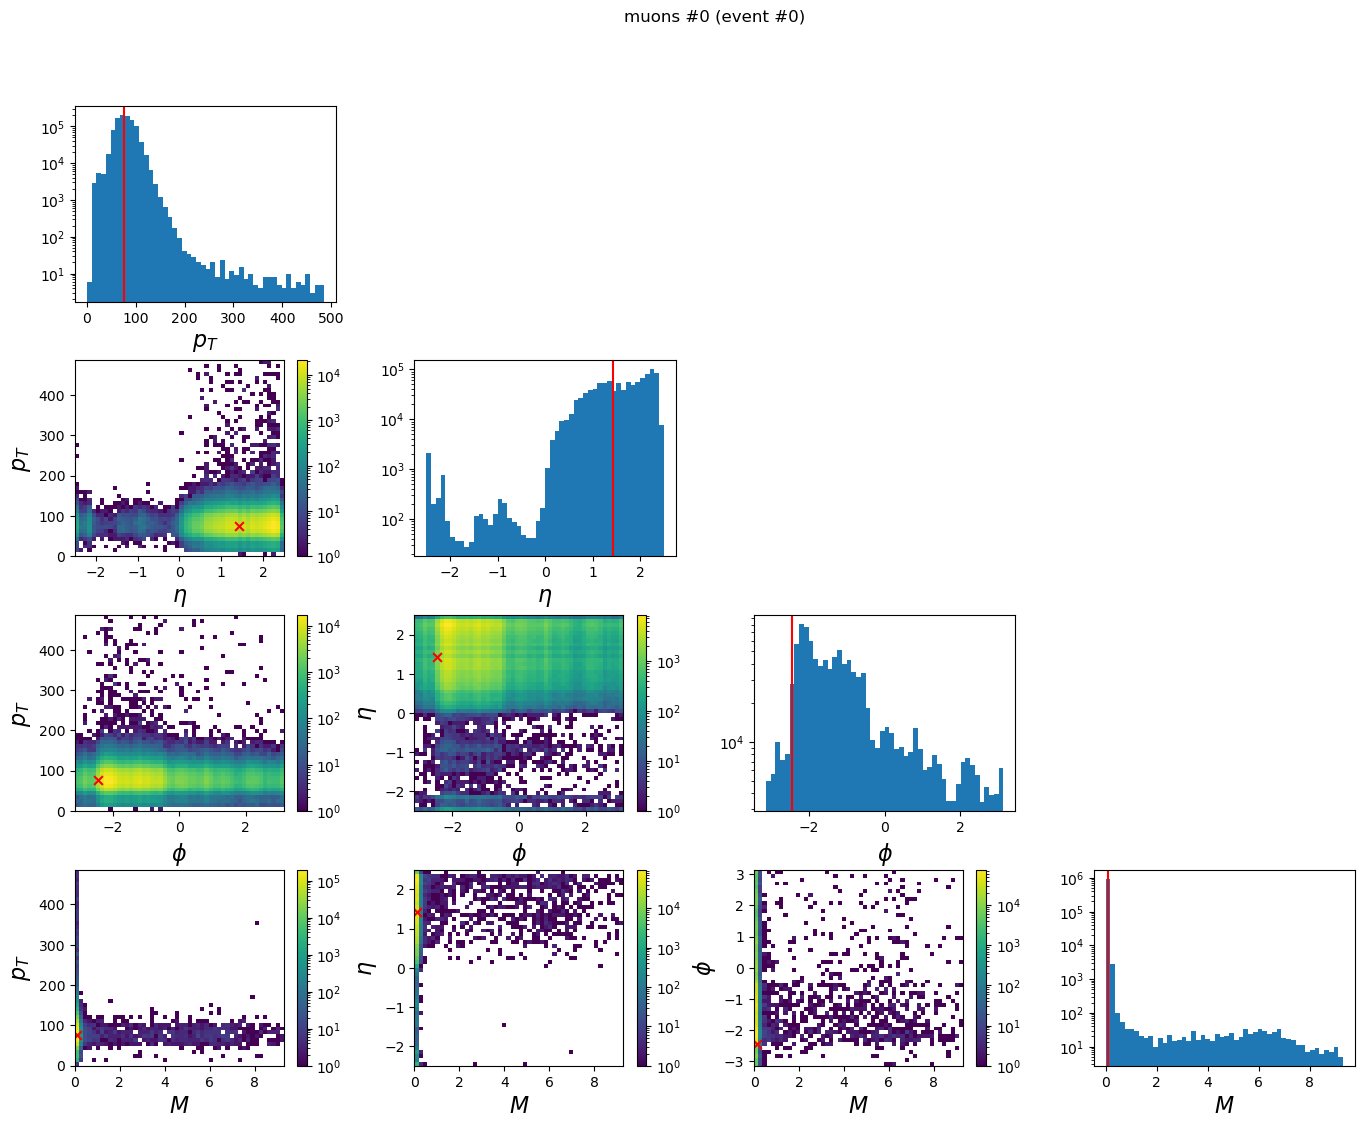

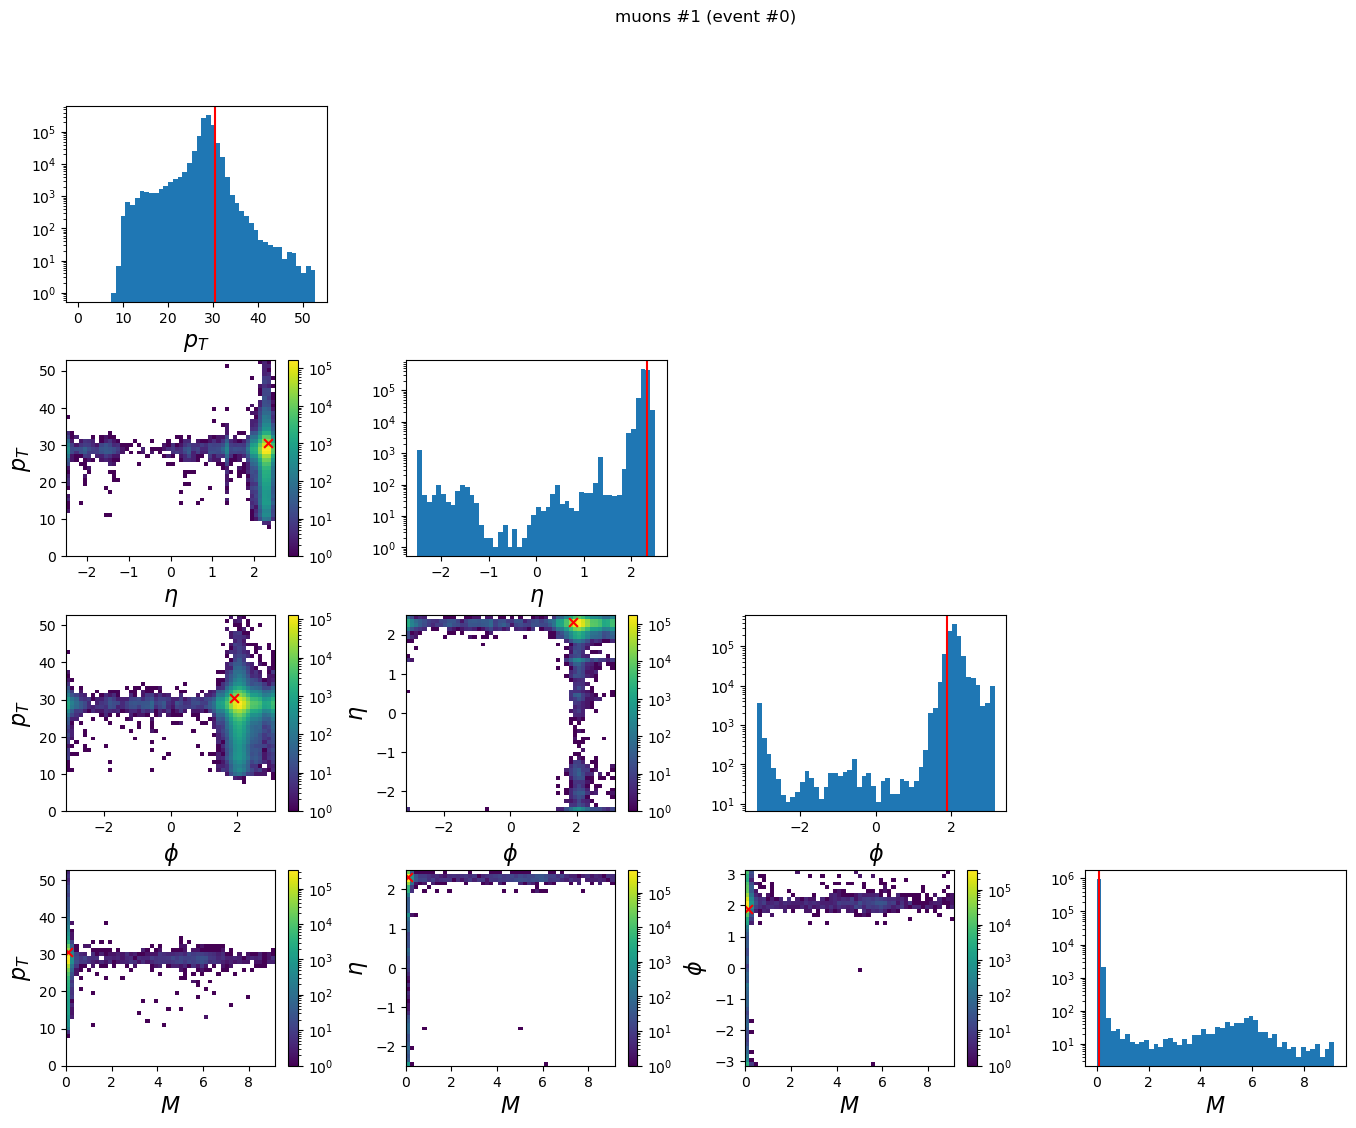

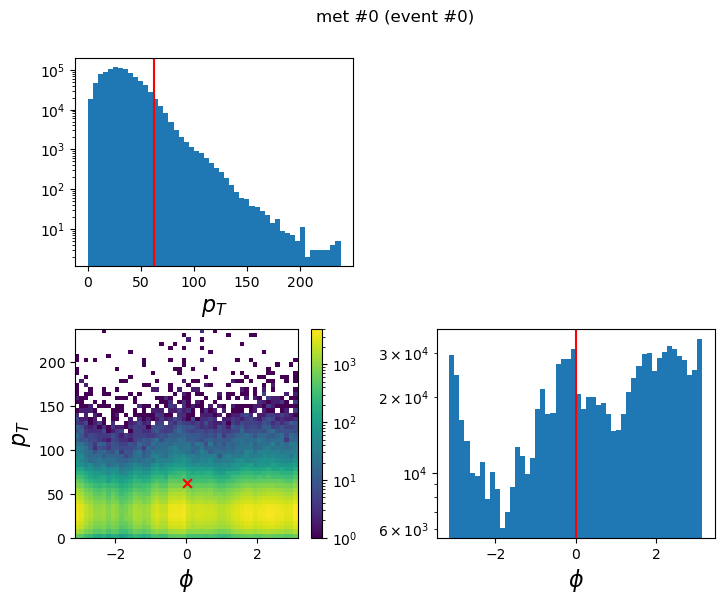

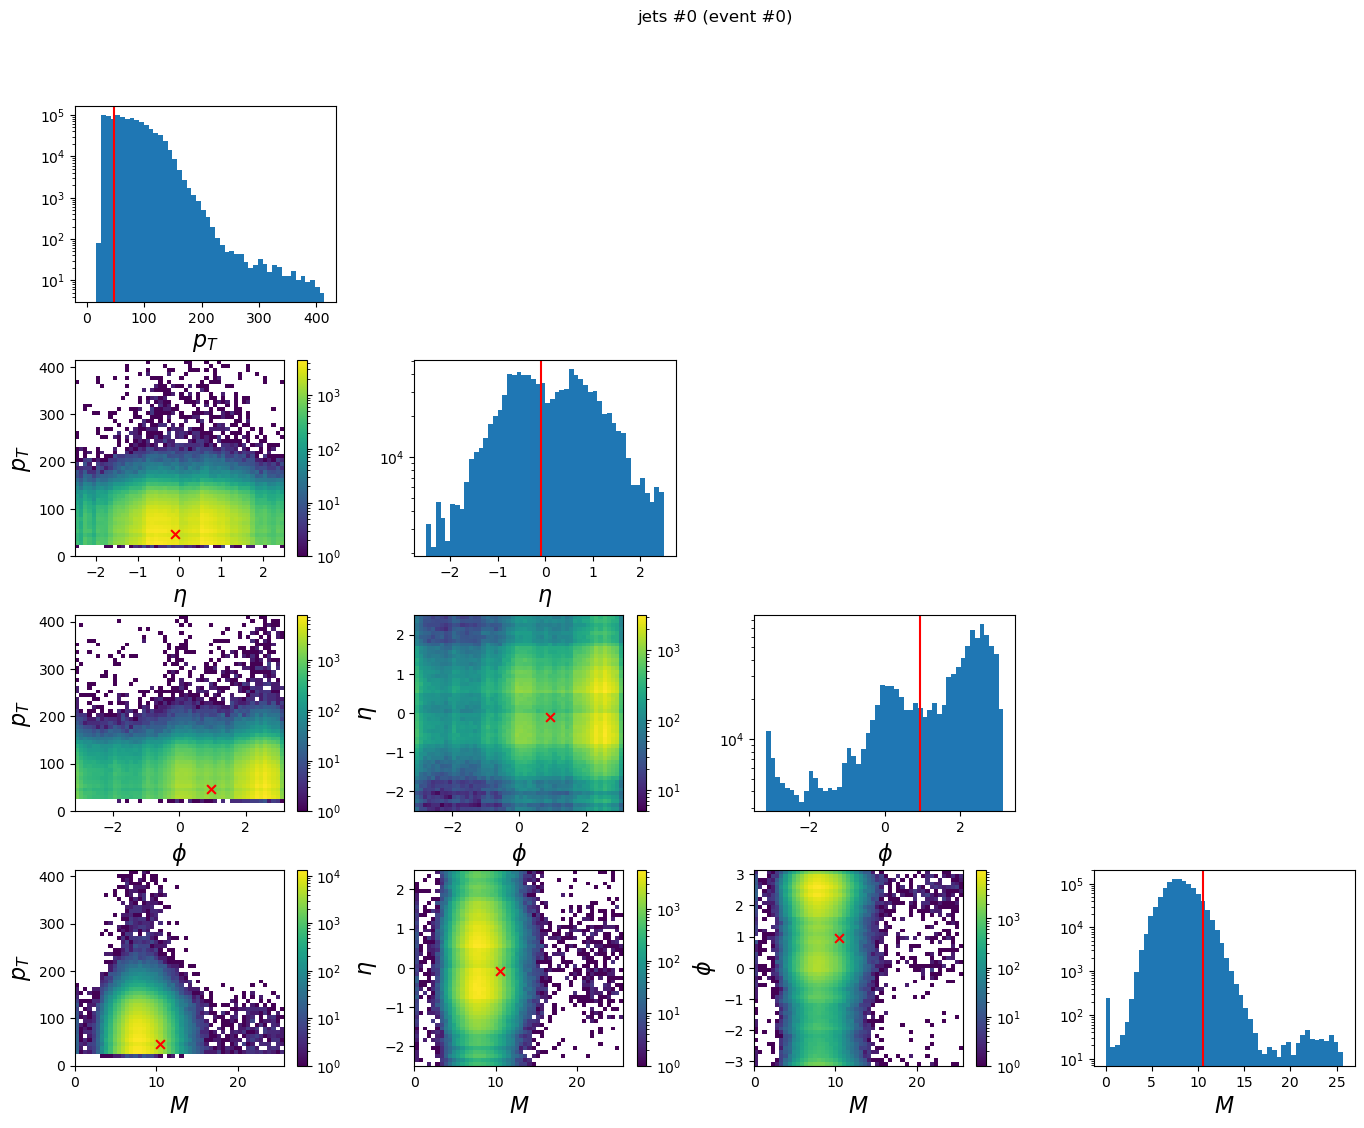

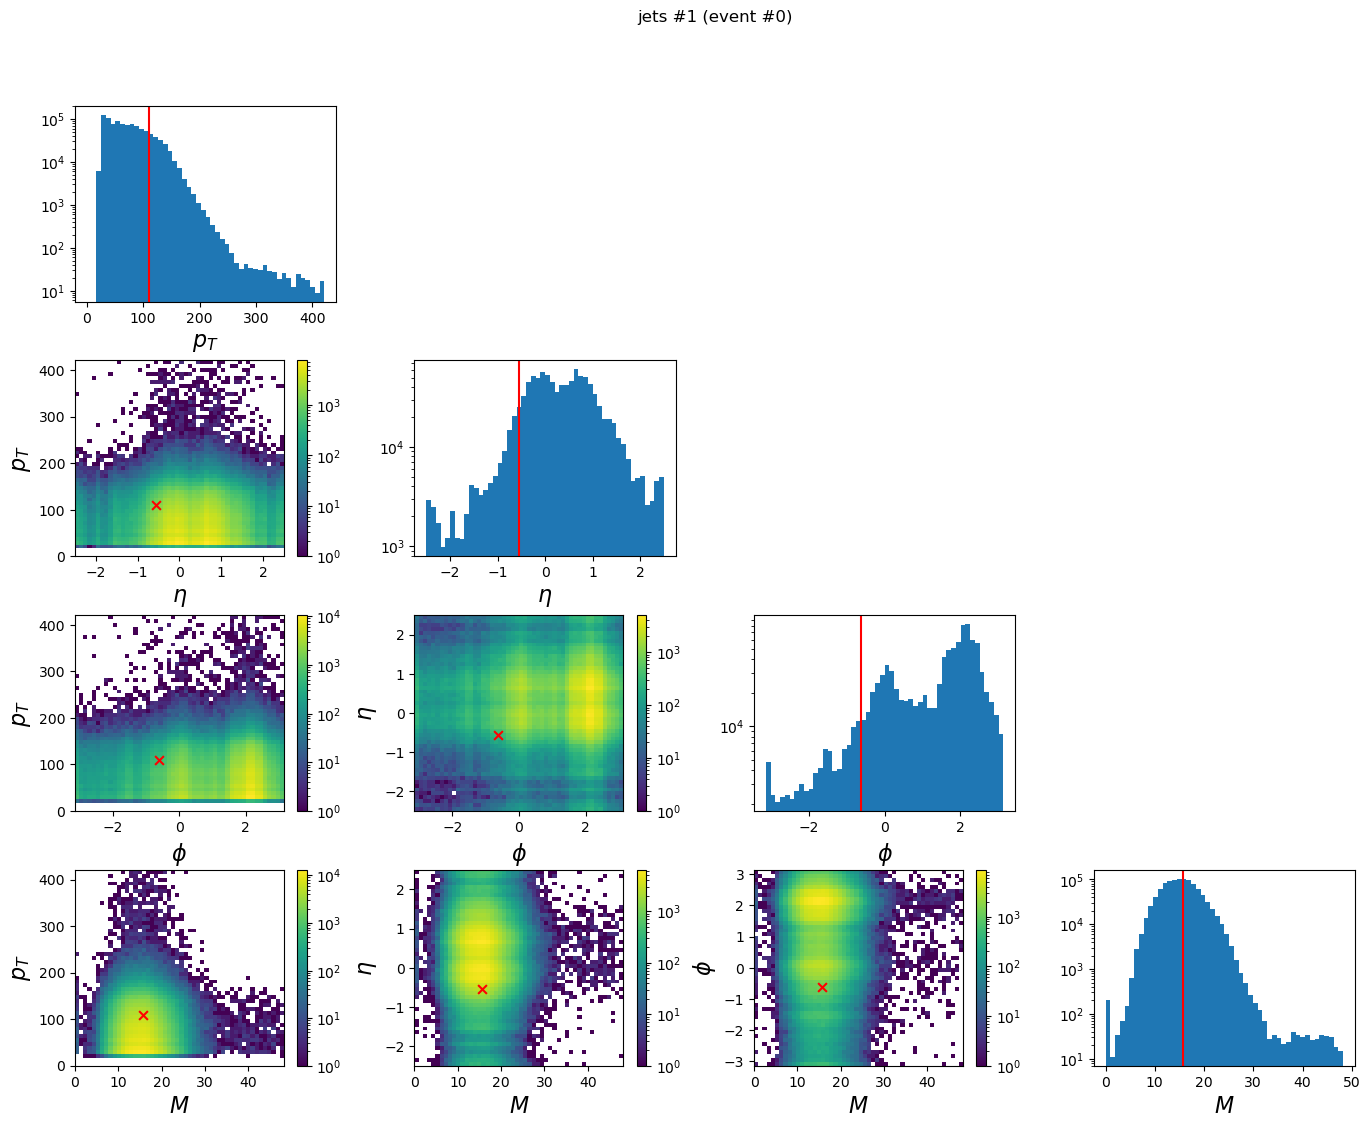

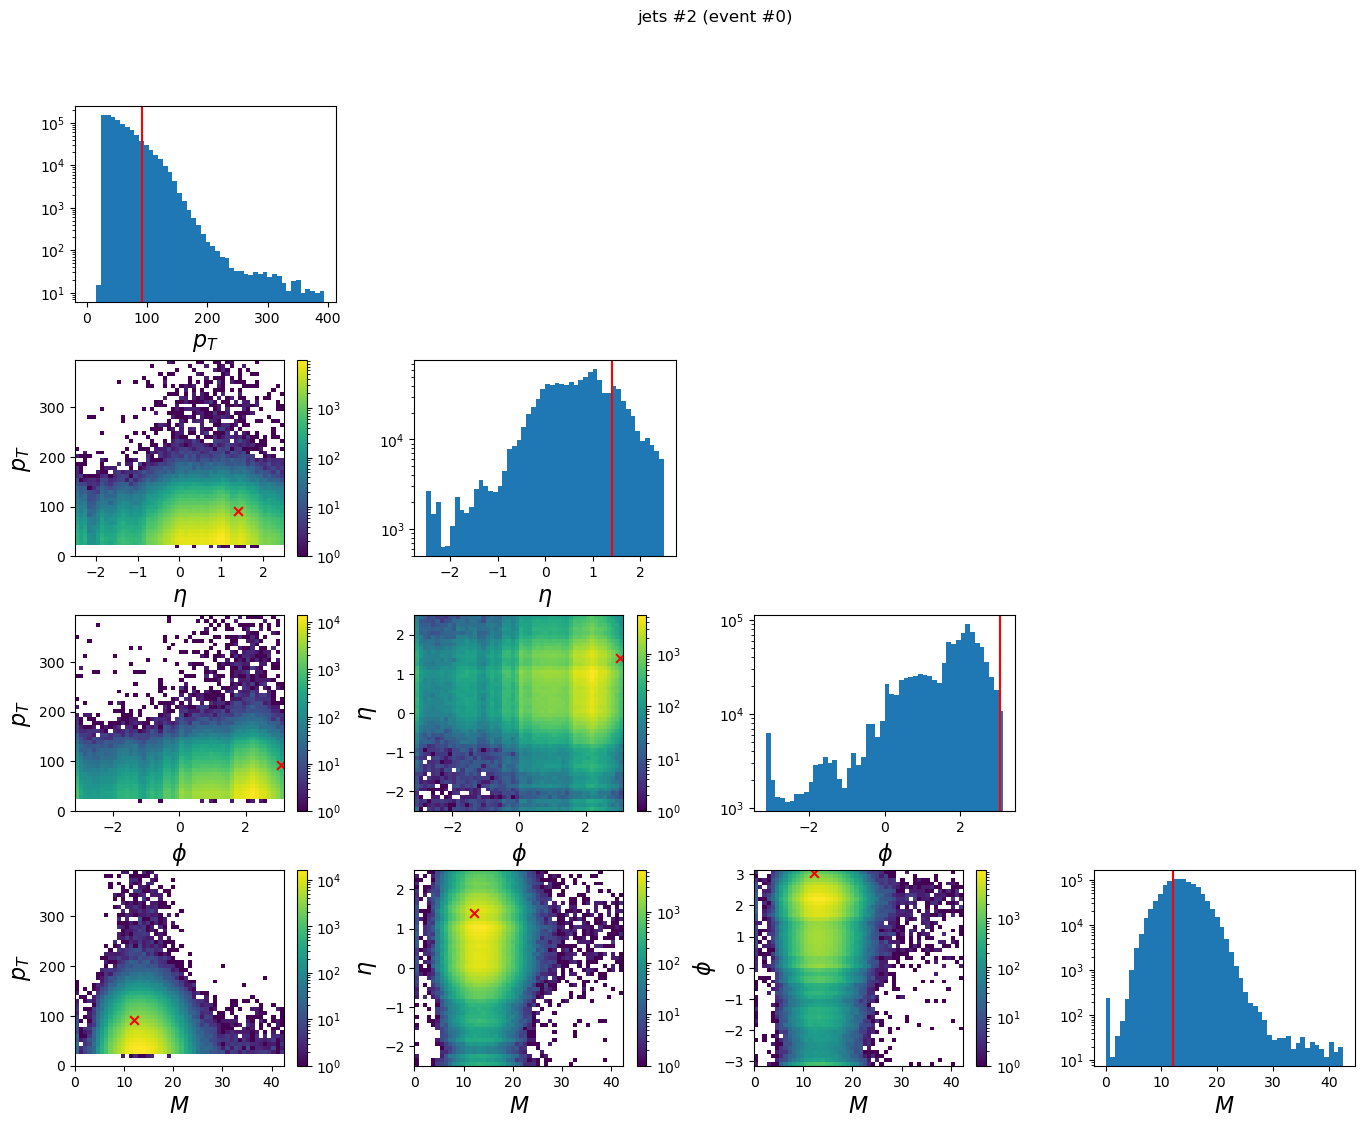

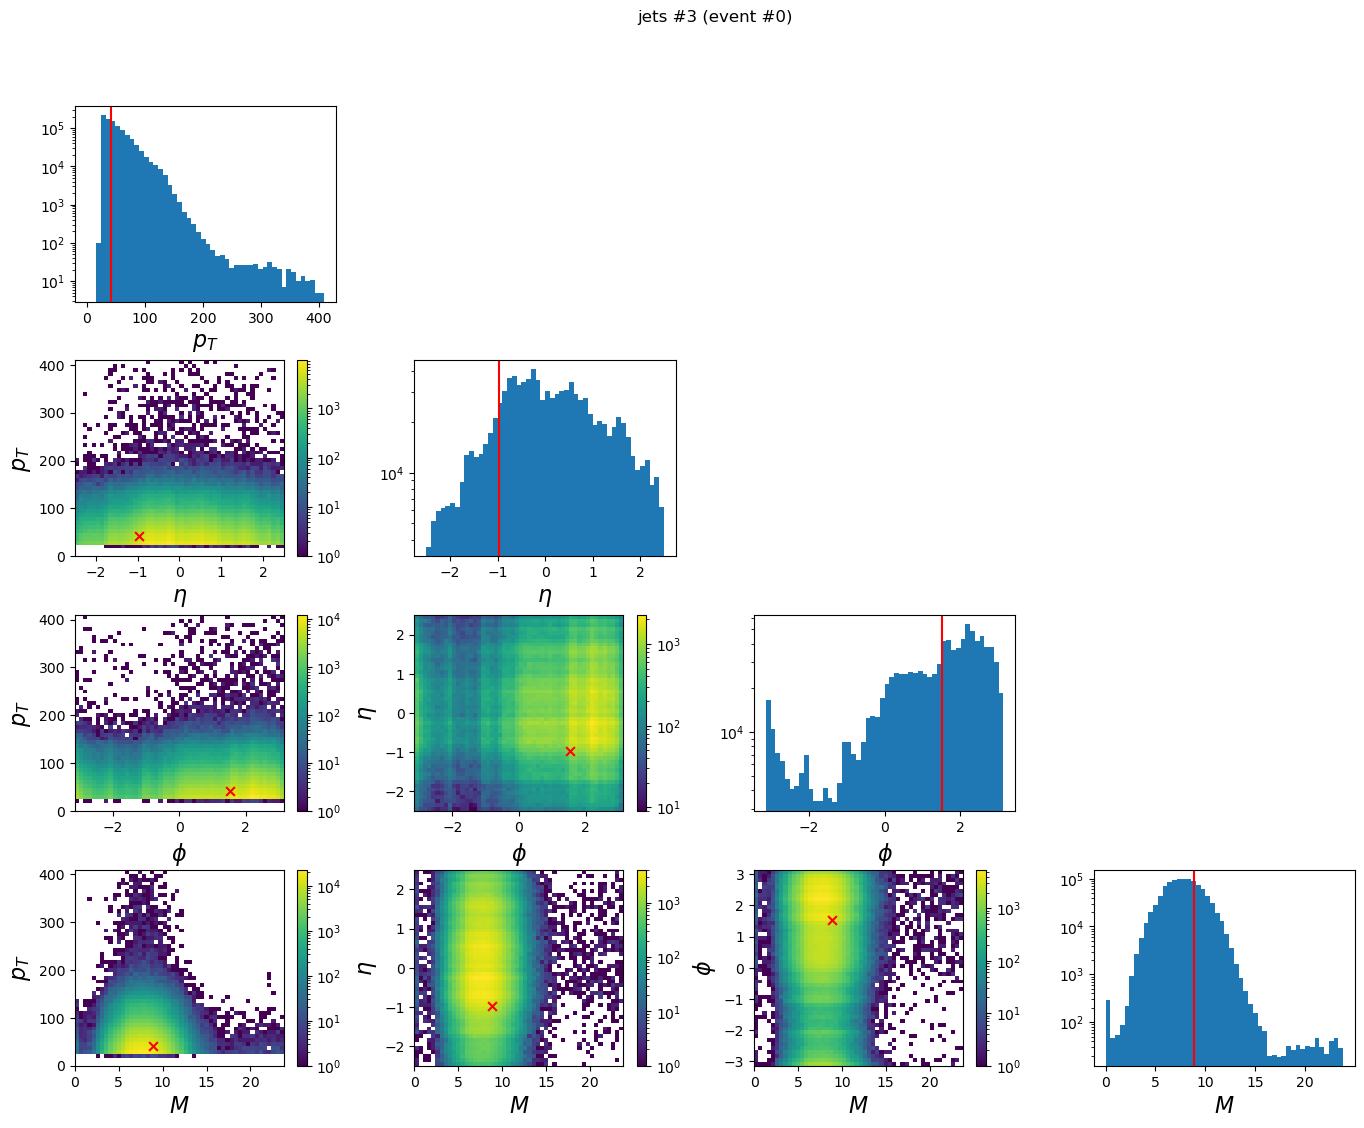

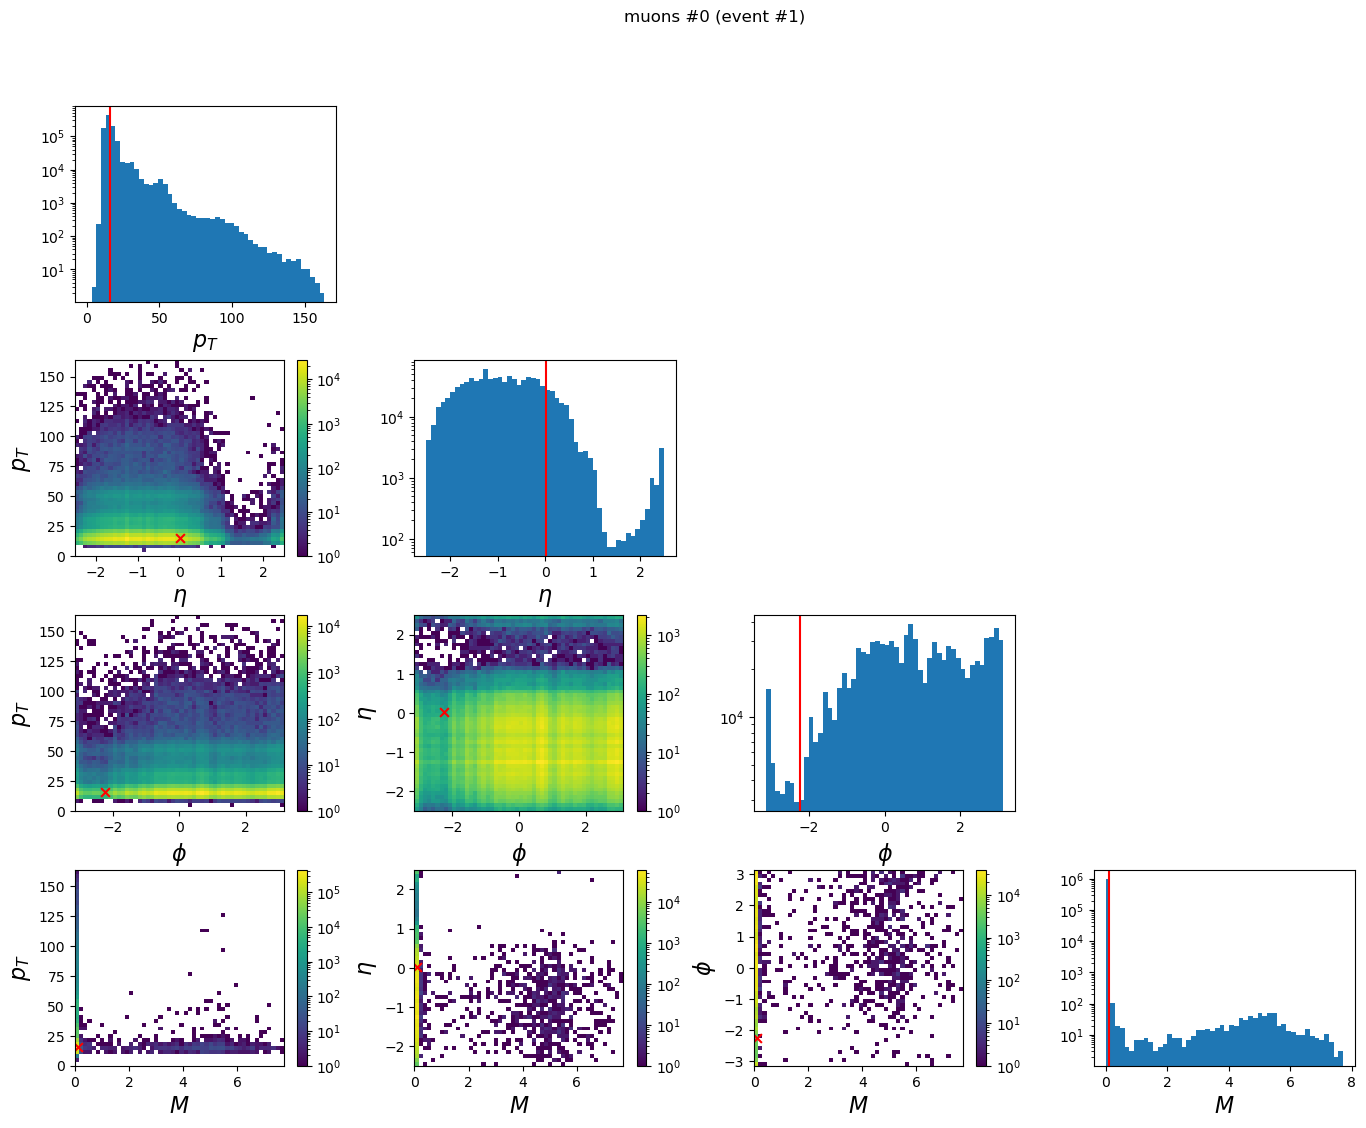

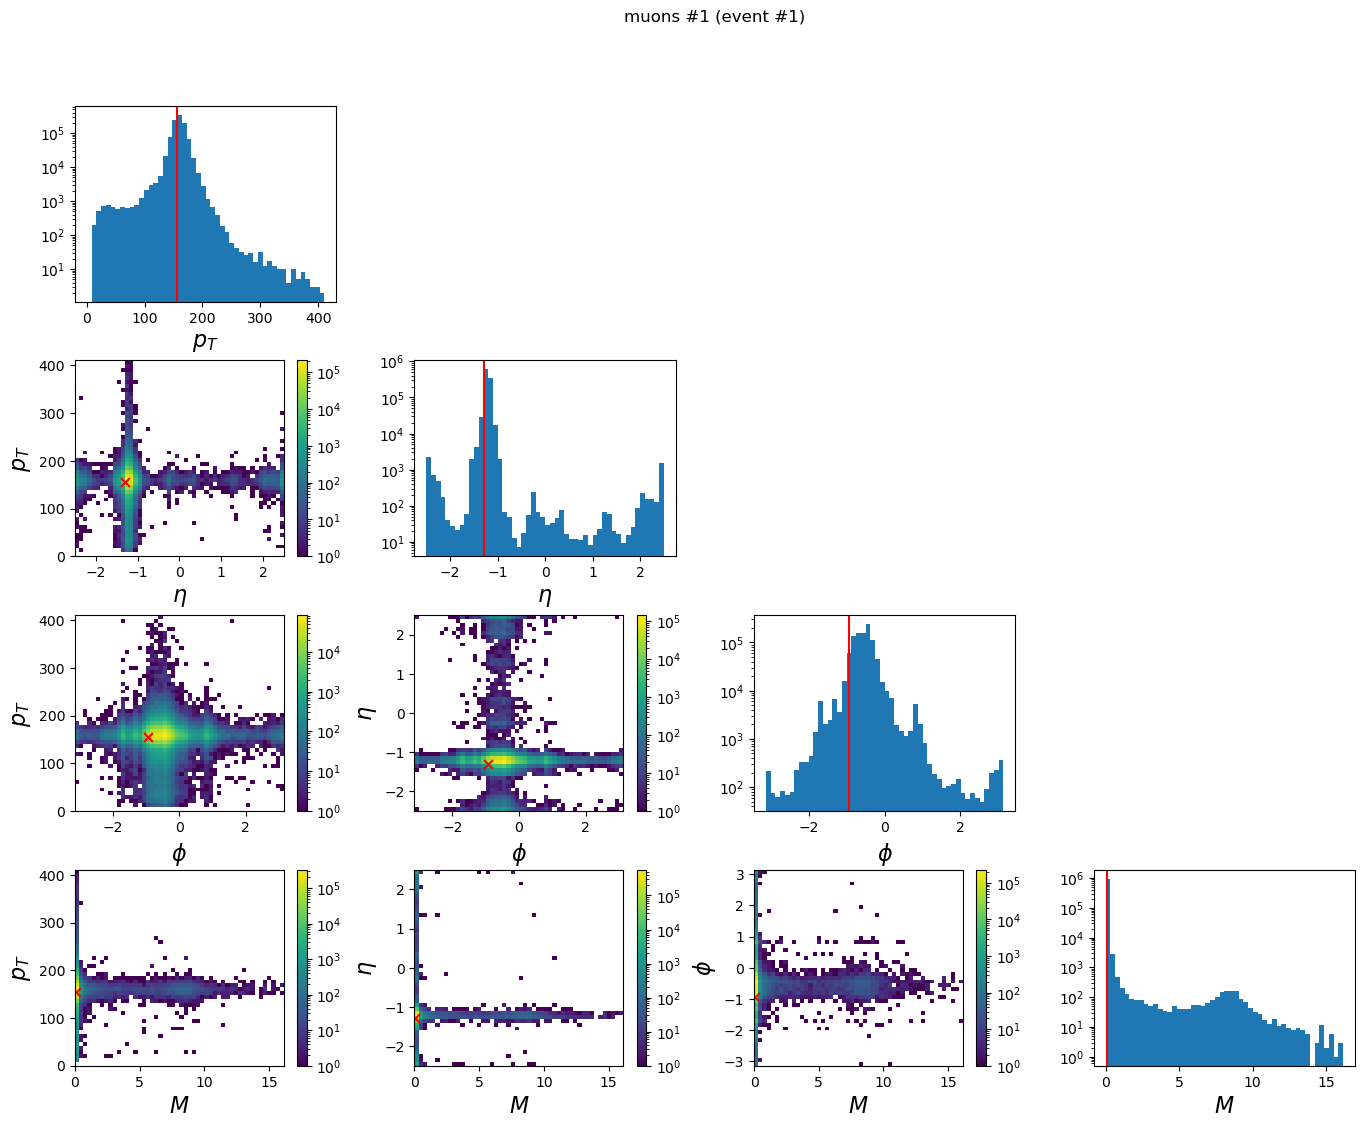

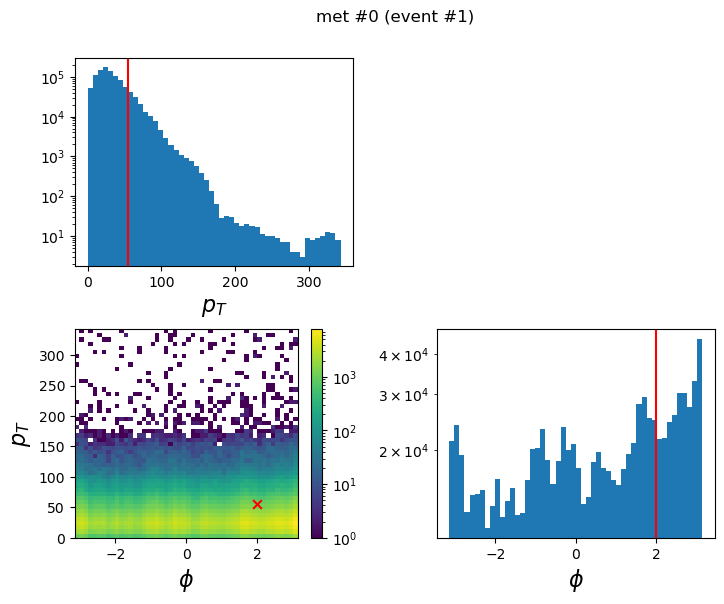

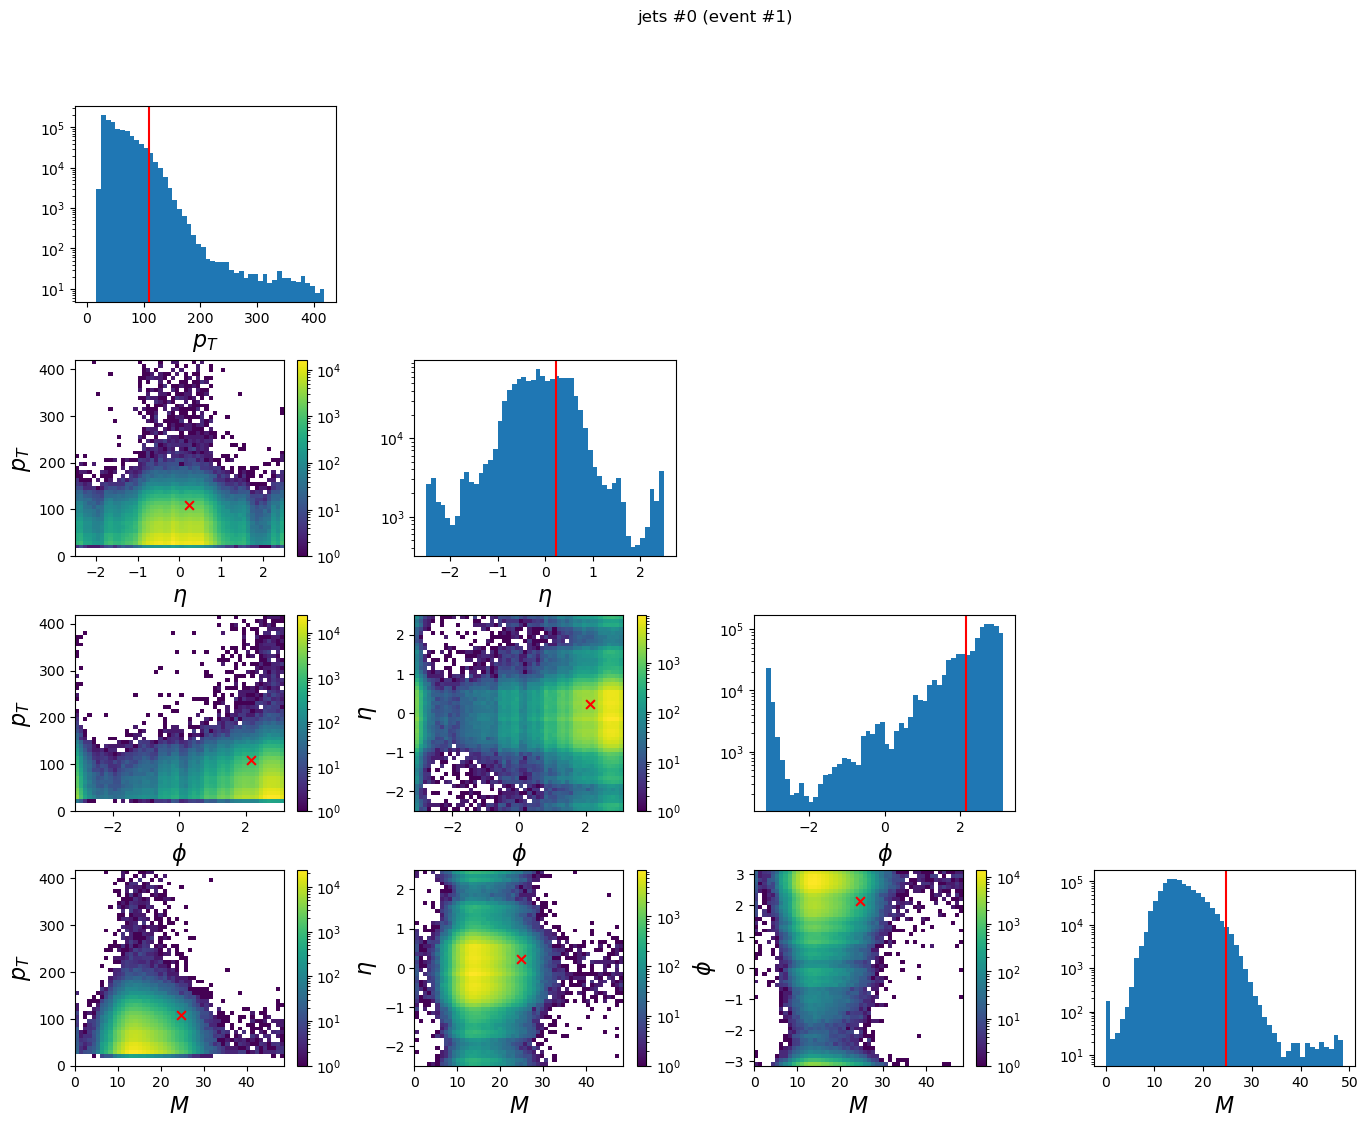

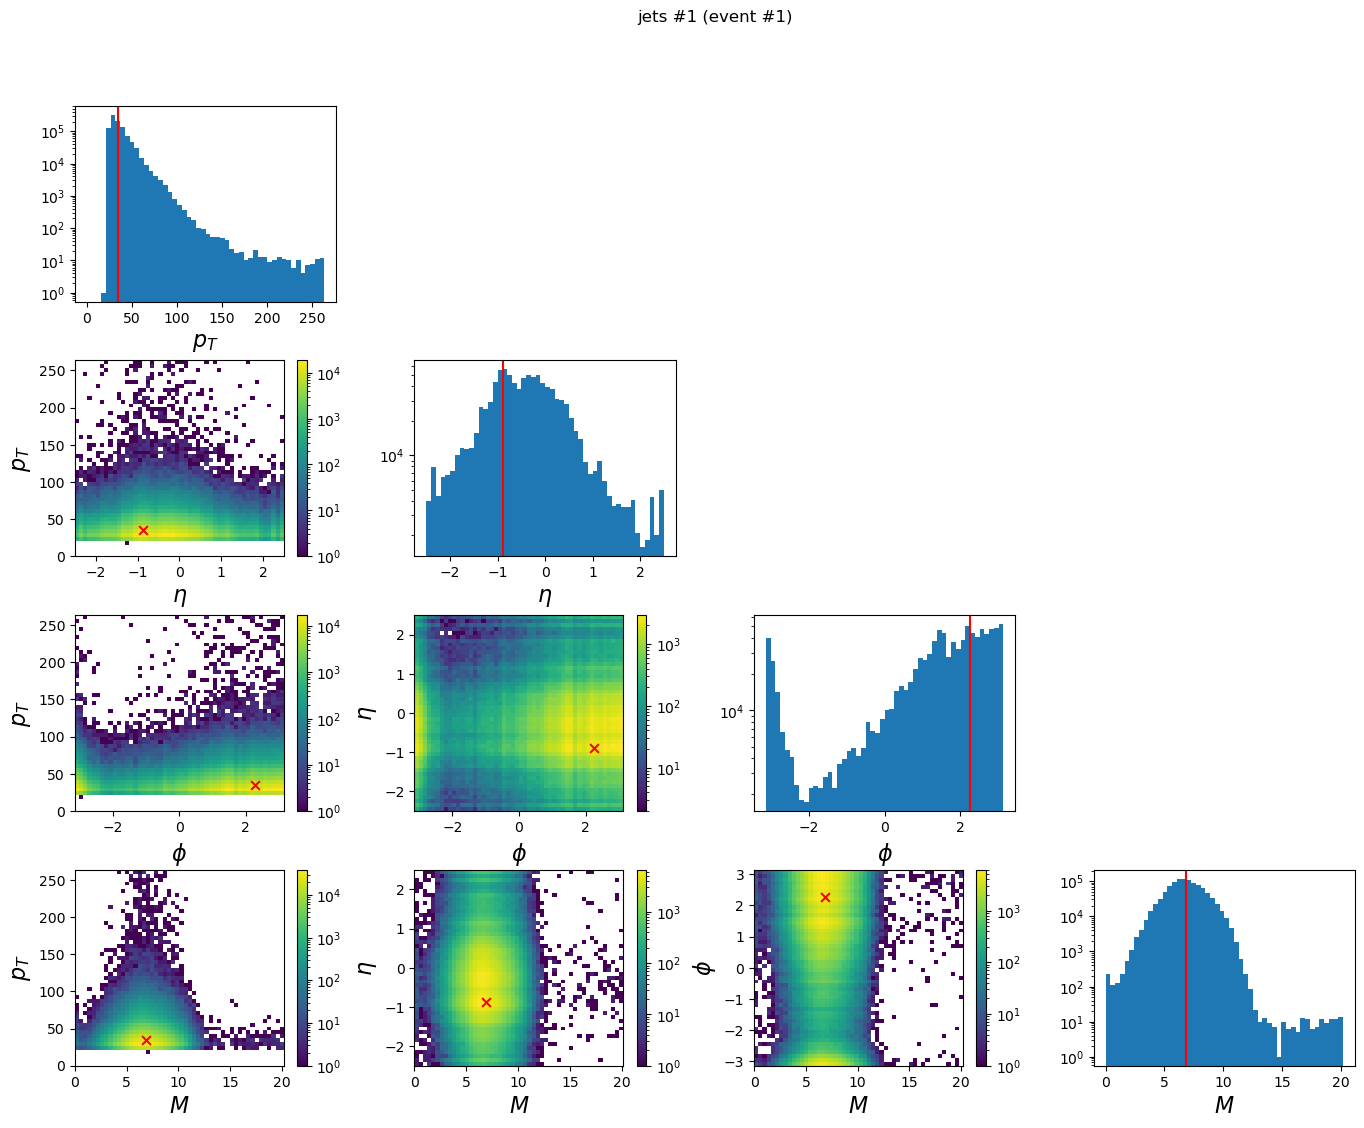

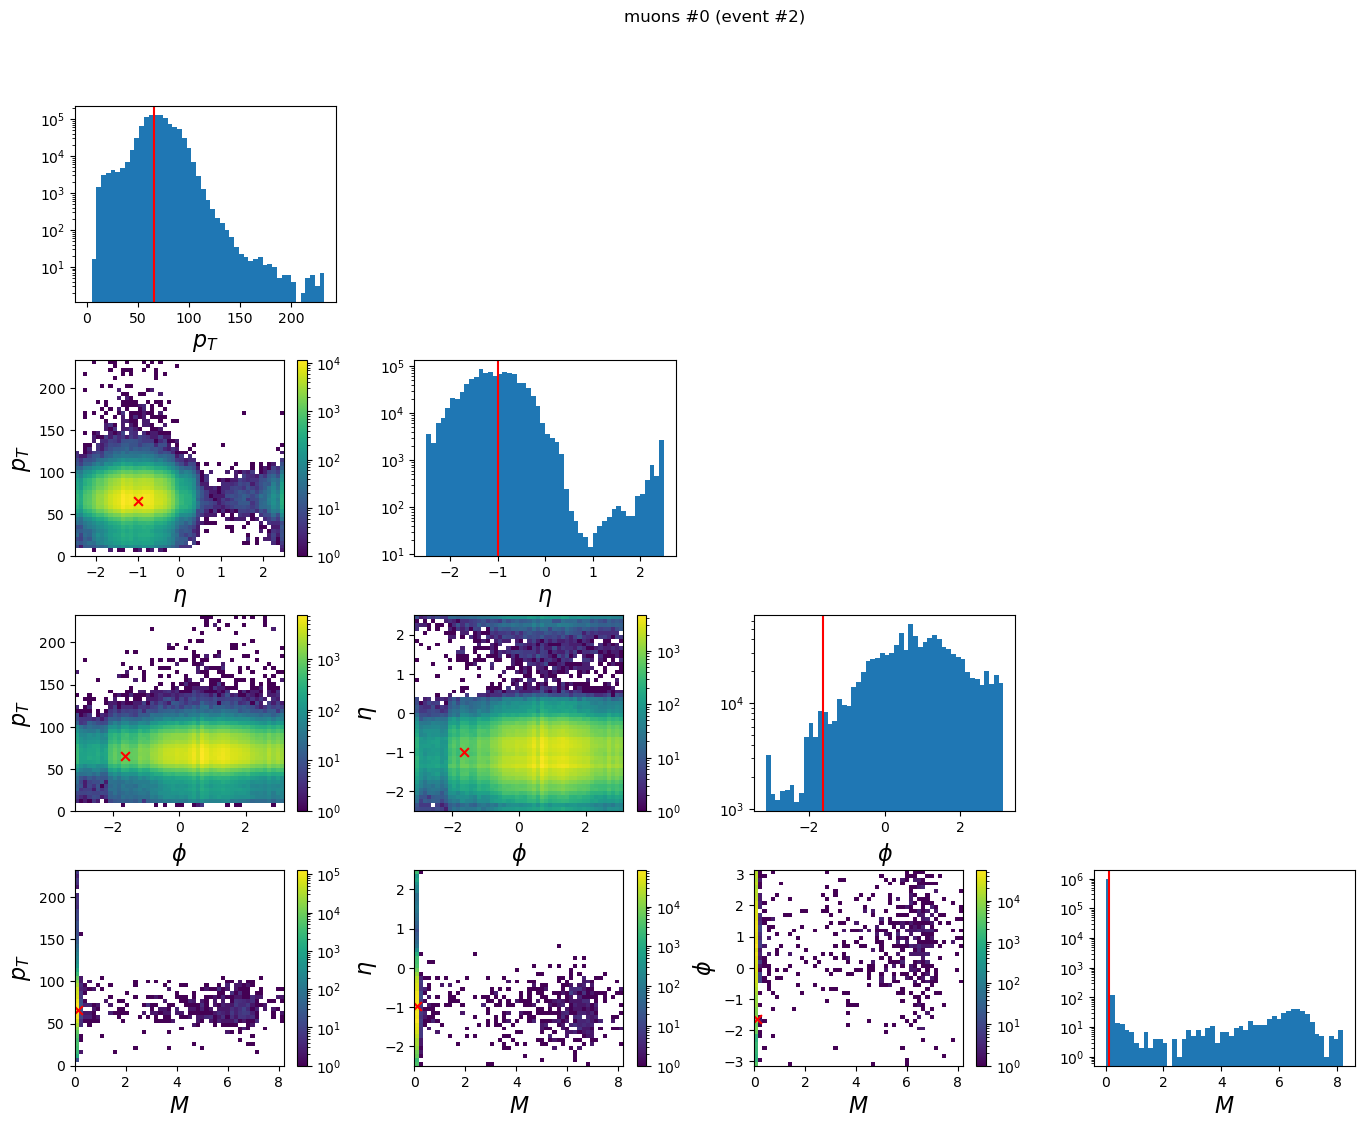

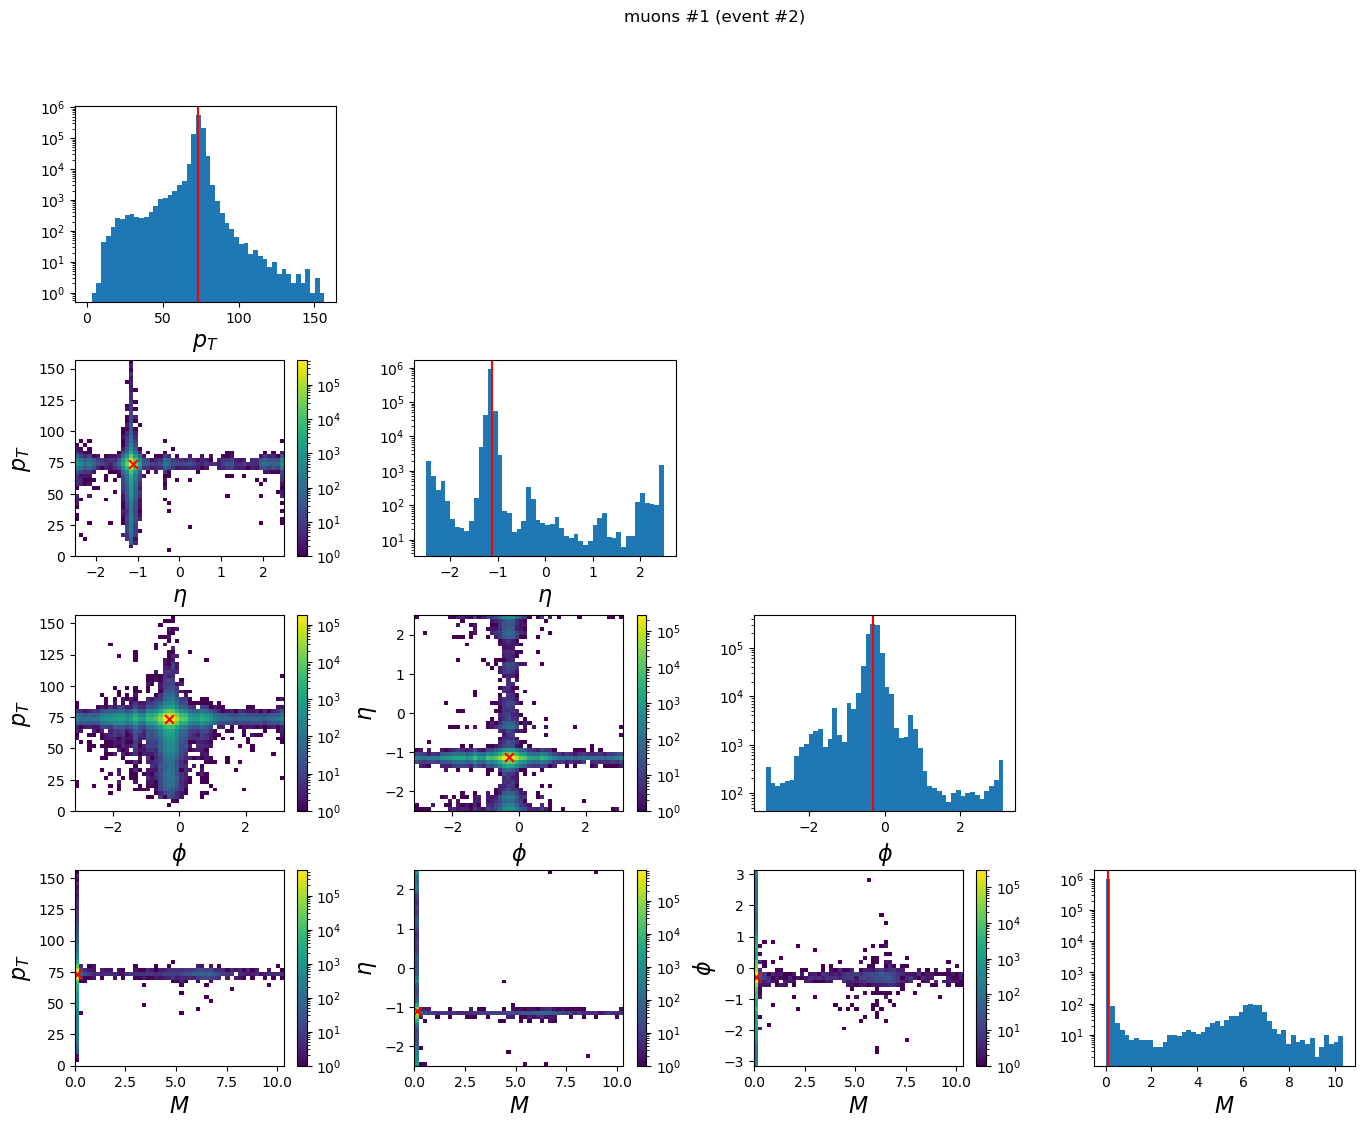

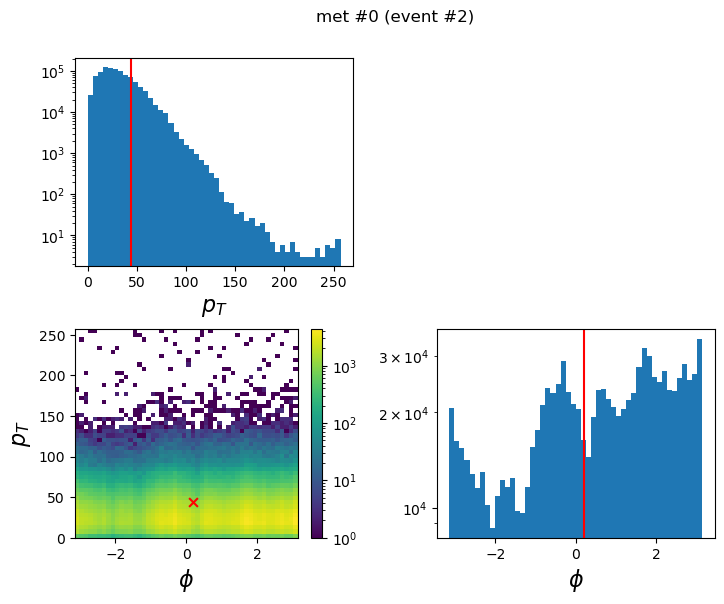

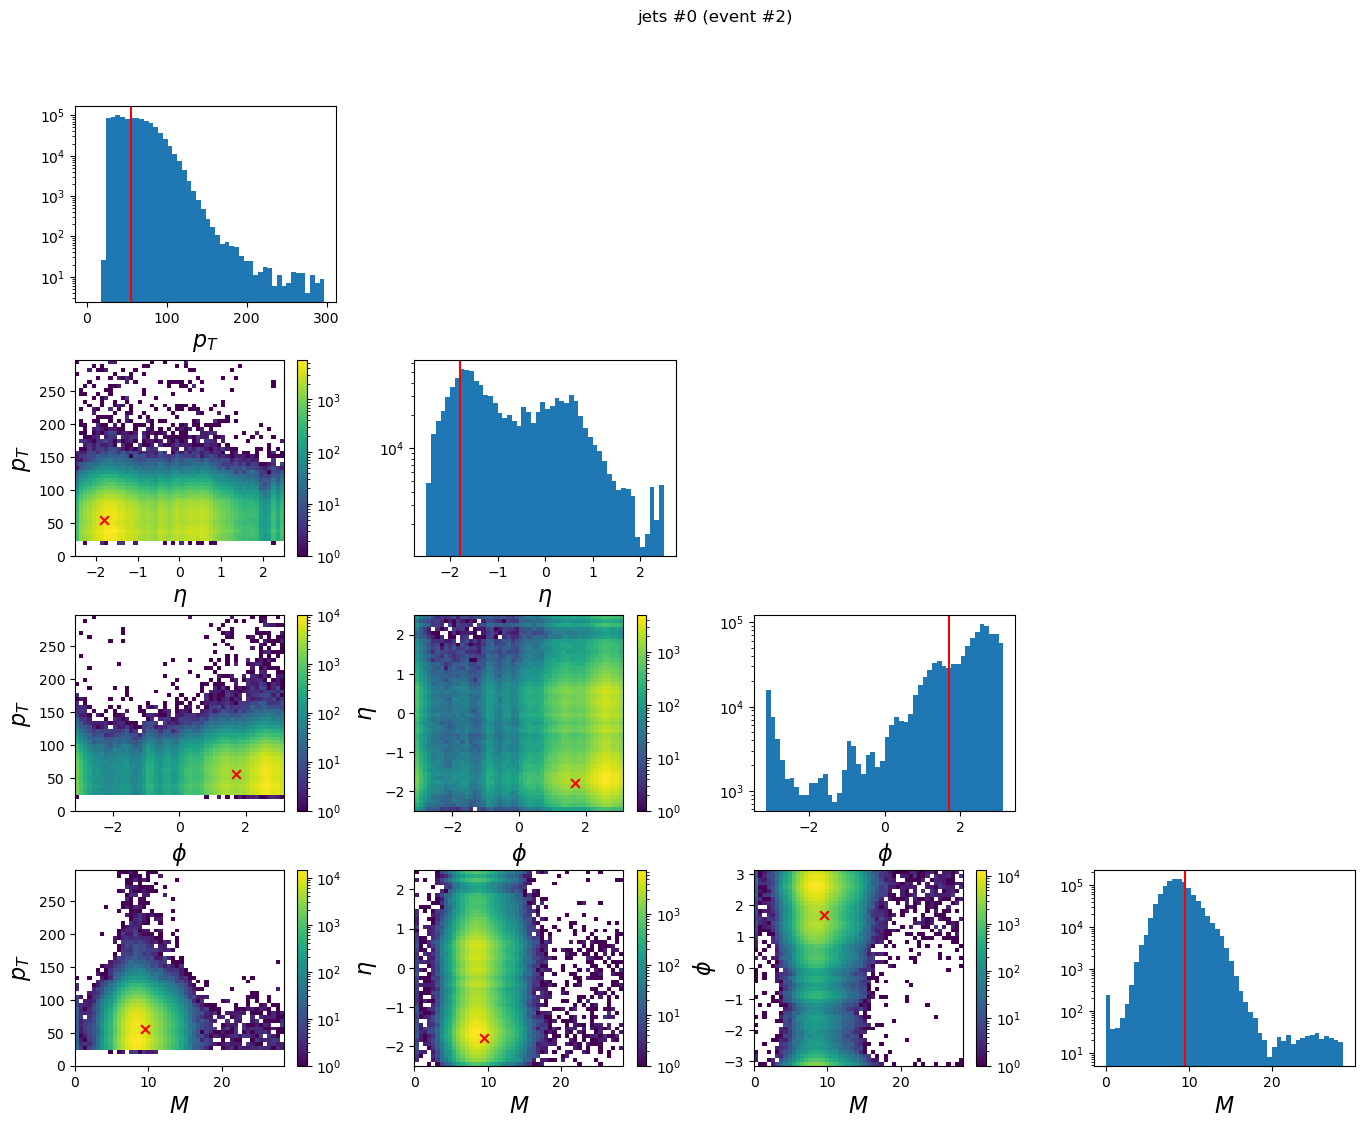

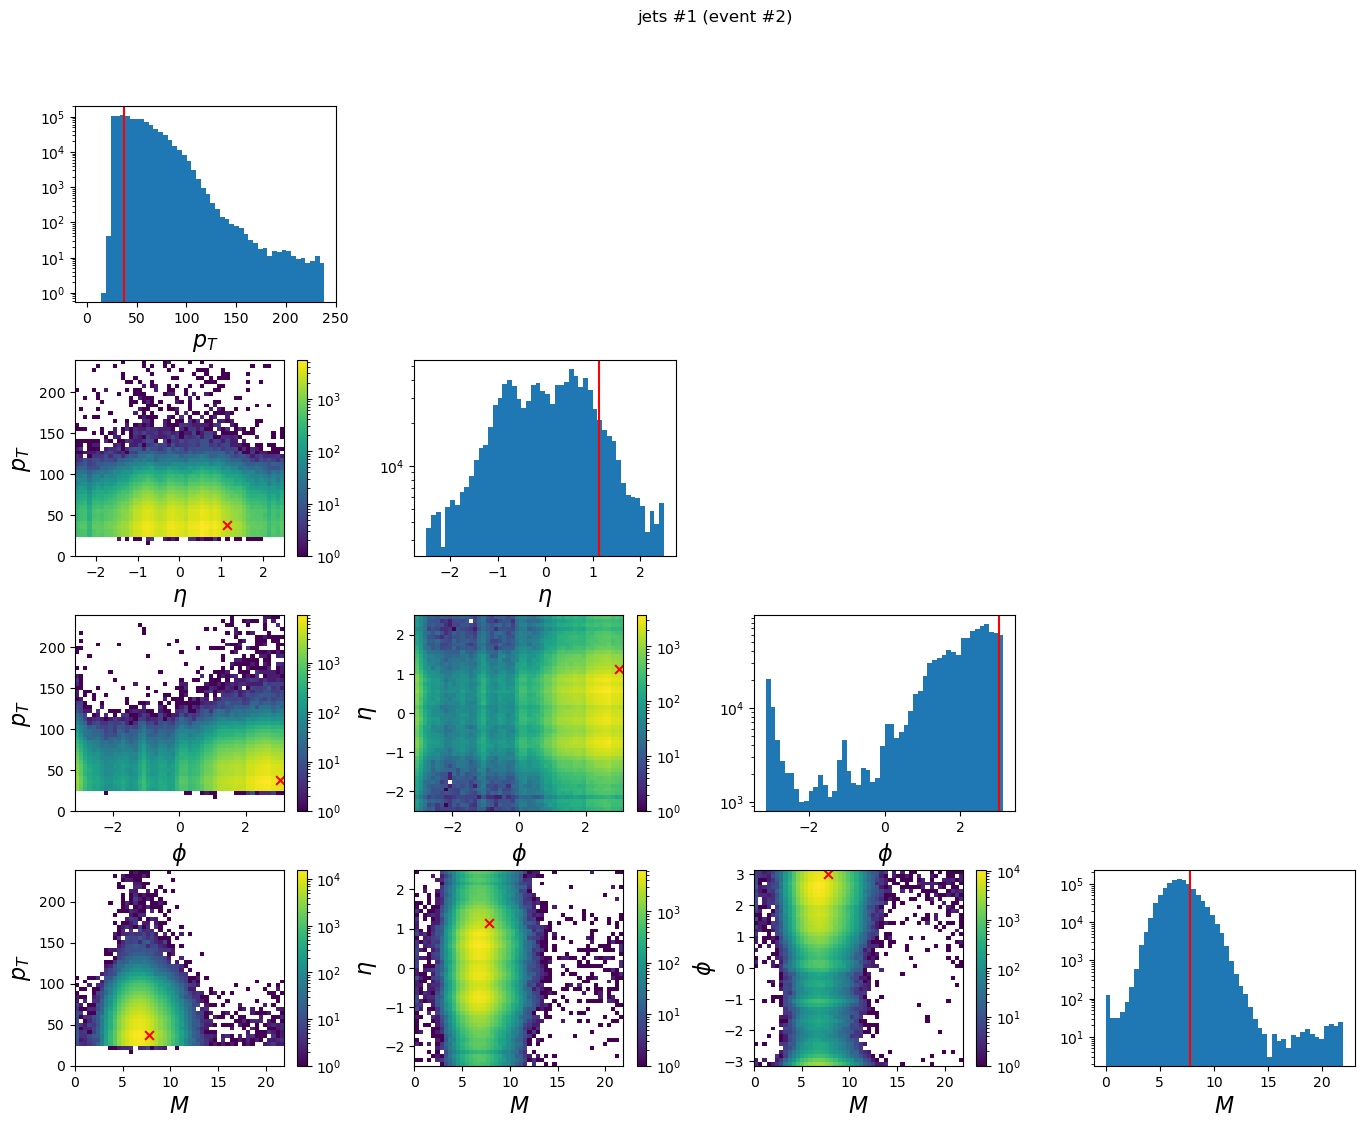

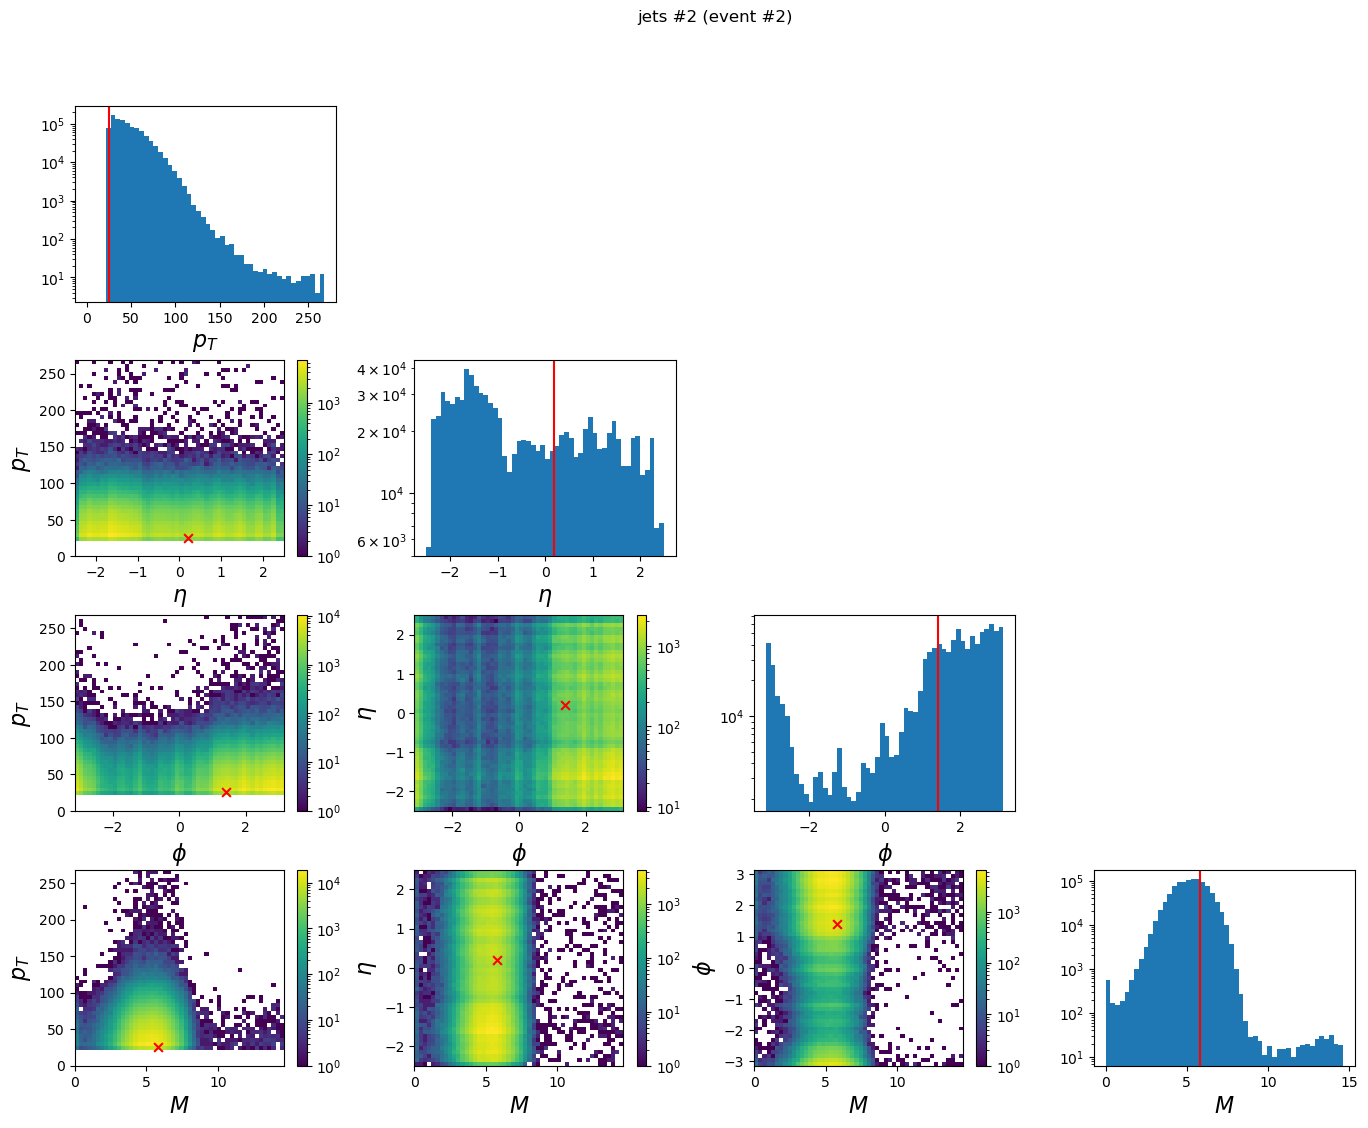

In [11]:
idx_to_monitor = [0,1,2]
samplings = [
    SamplingCallback(
        dataset = combined_valid_datasets[suffix],
        preprocessing = combined_datasets[suffix].reco_dataset._preprocessing,
        idx_to_monitor = idx_to_monitor,
        N_sample = 1000000, 
        frequency = 5,
        bins = 51,
        log_scale = True,
        label_names = {
            'pt' : 'p_T',
            'eta' : '\eta',
            'phi' : '\phi',
            'mass' : 'M',
        },
    )
    for suffix in suffixes
]
for sampling in samplings:
    figs = sampling.make_sampling_plots(model.cuda(),show=True)


In [ ]:
torch.save(model,'TF_combined.pt')